# Дипломный проект  
## Определение уязвимых групп населения и кластеризация регионов России  

### Часть 3. Кластеризация

**Описание проекта**

Цель данного проекта:
- кластеризовать регионы России и определить, какие из них наиболее остро нуждаются в помощи малообеспеченным/неблагополучным слоям населения;
- описать группы населения, сталкивающиеся с бедностью;
- определить факторы, влияющие на уровень бедности.

Для этого собираются и объединяются данные Росстата по ключевым направлениям, отражающим благосостояние населения, развитие экономики и социальную напряжённость. Перечень показателей включает данные о доходах, бедности, промышленном производстве, структуре инвалидности, рождаемости, доступности жилья, алкогольных и наркотических психозах, занятости, региональном продукте и другие.

**В данной части** проводится подготовка данных для модели и кластеризация регионов России. Цель анализа - выделить группы регионов, схожих по профилю социально-экономического неблагополучия, и определить территории, испытывающие наиболее серьёзные риски бедности и социальной напряжённости.

**Этапы работы:**

- Проверка пропусков в финальных признаках.

На этом шаге выполняется диагностика пропусков, оценка их распределения по регионам и переменным, а также принятие решения по дальнейшему обращению с ними (удаление, заполнение или сохранение в неизменном виде).

- Логарифмирование правоскошенных признаков.

Ряд показателей имеет ярко выраженное правостороннее распределение. Для снижения влияния экстремальных значений и улучшения структуры данных проводится логарифмирование, что способствует уменьшению скошенности распределений, снижению влияния крупных регионов-«выбросов», улучшению качества кластеризации.

- Масштабирование признаков.

Поскольку переменные имеют различную природу и измеряются в несопоставимых единицах (рубли, проценты, на 1000 населения и т. д.), применяется стандартизация, позволяющая корректно использовать алгоритмы, чувствительные к масштабу (PCA, KMeans).

- Выбор числа кластеров.

Производится подбор оптимального количества кластеров с помощью метрик.

- Кластеризация регионов.

После определения оптимального количества кластеров выполняются различные методы кластеризации, а их результаты - сопоставляются и анализируются. На основе сравнения качества разбиения, стабильности решений и интерпретируемости получаемых групп выбирается наиболее подходящая модель кластеризации регионов.

- Интерпретация кластеров.

На итоговом этапе проводится характеристика выделенных групп регионов.

**Результатом** этой части проекта будет: 
- описание социально-экономических особенностей каждого кластера,
- выявление наиболее уязвимых регионов,
- определение ключевых факторов бедности,
- сопоставление результатов с задачами исследования.

In [1]:
# Необходимые библиотеки
import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import metrics
from sklearn.metrics import silhouette_score

from scipy.stats import kruskal, mannwhitneyu

In [2]:
# Загрузка данных
df_cluster = pd.read_csv("../data_processed/data_for_clustering.csv")

display(df_cluster.head(5))
print("Размер датасета:", df_cluster.shape)  
display(df_cluster.info())

,region,birth_rate_per_1000,infant_mortality_per_1000,cash_income_per_capita,poverty_percent,poor_children_share,poor_old_share,disabled_per_1000,drug_alco_rate,area_living_per_capita,hh_high_crowding,hh_plan_improve,grp_per_capita,industry_total,retail_to_income,crime_prev_convicted,crime_intox_alcohol,welfare_expense_share,workers_share
0,Алтайский край,8.620924,4.855827,23864.0,17.5,31.4,9.2,72.618856,58.6,18.0,3.3,14.9,291156.9,4.262217e+08,6.436683,7278.0,9396.0,29.7,78.6
1,Амурская область,9.939953,5.348275,35499.0,15.2,38.4,4.7,79.262674,67.1,17.3,5.9,14.7,571362.1,2.022882e+08,6.908166,3078.0,3123.0,21.7,84.8
2,Архангельская область,8.358740,3.473684,36779.0,12.8,30.2,6.7,73.434606,60.9,NaN,NaN,NaN,697648.2,5.950092e+08,6.772914,3522.0,4011.0,21.4,82.3
3,Архангельская область без АО,8.152512,3.256232,34852.0,12.3,28.5,7.2,NaN,NaN,16.9,2.2,13.4,514200.4,3.320535e+08,7.174136,NaN,NaN,NaN,80.2
4,Астраханская область,9.844082,6.463994,25199.0,15.6,42.1,5.5,42.722976,NaN,19.2,3.1,16.4,526950.9,3.622989e+08,6.925949,2622.0,2534.0,31.4,80.3


Размер датасета: (87, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   region                     87 non-null     object 
 1   birth_rate_per_1000        87 non-null     float64
 2   infant_mortality_per_1000  87 non-null     float64
 3   cash_income_per_capita     87 non-null     float64
 4   poverty_percent            87 non-null     float64
 5   poor_children_share        75 non-null     float64
 6   poor_old_share             75 non-null     float64
 7   disabled_per_1000          85 non-null     float64
 8   drug_alco_rate             69 non-null     float64
 9   area_living_per_capita     85 non-null     float64
 10  hh_high_crowding           85 non-null     float64
 11  hh_plan_improve            85 non-null     float64
 12  grp_per_capita             87 non-null     float64
 13  industry_total            

None

In [3]:
# Фиксируем список признаков
features_final = ["birth_rate_per_1000",
                  "infant_mortality_per_1000",
                  
                  "cash_income_per_capita",
                  "poverty_percent",
                  "poor_children_share",
                  "poor_old_share",
                  
                  "disabled_per_1000",
                  "drug_alco_rate",
                  
                  "area_living_per_capita",
                  "hh_high_crowding",
                  "hh_plan_improve",
                  
                  "grp_per_capita",
                  "industry_total",
                  
                  "retail_to_income",
                  
                  "crime_prev_convicted",
                  "crime_intox_alcohol",
                  
                  "welfare_expense_share",
                  
                  "workers_share"
                 ]

id_cols = ["region"]

### 1. Анализ пропусков в финальных признаках

Перед применением методов кластеризации необходимо проверить качество данных по итоговому набору признаков.  
В этом разделе анализируются пропуски в финальных переменных:

- оценивается общее количество пропусков;
- для каждого признака рассчитывается число и доля отсутствующих значений;
- проверяется, существуют ли регионы с неполным набором показателей.

Полученные результаты будут учтены при выборе стратегии предобработки (удаление наблюдений с пропусками или использование методов заполнения).

In [4]:
# Общее количество пропусков
print("\nОбщее число пропусков во всех столбцах:", df_cluster.isna().sum().sum())

# Число строк с хотя бы одним пропуском
print("Число строк с хотя бы одним пропуском:", df_cluster.isna().any(axis=1).sum())

# Таблица по признакам: сколько пропусков и какая доля
na_stats = (df_cluster[features_final]
            .isna()
            .agg(["sum", "mean"])
            .T  
            .rename(columns={"sum": "missing_count", "mean": "missing_share"})
           )

na_stats["missing_share"] = (na_stats["missing_share"] * 100).round(2)

print("\nПропуски по признакам (отсортировано по числу пропусков):")
display(na_stats.sort_values("missing_count", ascending=False))



Общее число пропусков во всех столбцах: 56
Число строк с хотя бы одним пропуском: 30

Пропуски по признакам (отсортировано по числу пропусков):


,missing_count,missing_share
drug_alco_rate,18.0,20.69
poor_old_share,12.0,13.79
poor_children_share,12.0,13.79
crime_prev_convicted,2.0,2.30
crime_intox_alcohol,2.0,2.30
disabled_per_1000,2.0,2.30
area_living_per_capita,2.0,2.30
hh_high_crowding,2.0,2.30
welfare_expense_share,2.0,2.30
hh_plan_improve,2.0,2.30


In [5]:
# Создаём таблицу: для каждого региона список отсутствующих признаков
missing_details = (df_cluster[id_cols + features_final]
                   .set_index("region")[features_final]
                   .apply(lambda row: [col for col in features_final if pd.isna(row[col])], axis=1)
                   .to_frame(name="missing_features")
                  )

# Считаем количество пропусков
missing_counts = (df_cluster[id_cols + features_final]
                  .set_index("region")[features_final]
                  .isna()
                  .sum(axis=1)
                  .to_frame(name="missing_count")
                 )

# Объединяем
missing_table = missing_counts.join(missing_details)

# Сортируем по количеству пропусков
missing_table_sorted = missing_table.sort_values("missing_count", ascending=False)

display(missing_table_sorted.head(20))

,missing_count,missing_features
region,,
Архангельская область без АО,5,"[disabled_per_1000, drug_alco_rate, crime_prev..."
Тюменская область без АО,5,"[disabled_per_1000, drug_alco_rate, crime_prev..."
Тюменская область,4,"[drug_alco_rate, area_living_per_capita, hh_hi..."
Архангельская область,3,"[area_living_per_capita, hh_high_crowding, hh_..."
г. Севастополь,3,"[poor_children_share, poor_old_share, drug_alc..."
Ивановская область,2,"[poor_children_share, poor_old_share]"
Белгородская область,2,"[poor_children_share, poor_old_share]"
Республика Мордовия,2,"[poor_children_share, poor_old_share]"
Ненецкий автономный округ,2,"[poor_children_share, poor_old_share]"


Отдельно рассмотрим составные субъекты вида «область без автономного округа» (Архангельская область без АО, Тюменская область без АО). Поскольку соответствующие автономные округа (Ненецкий АО, ХМАО, ЯНАО) присутствуют в данных как самостоятельные регионы, такие агрегированные записи дублируют информацию и содержат неполные наборы показателей. В связи с этим они будут исключены из выборки перед проведением кластеризации. Остальные признаки заполним медианой.

In [6]:
df_model = df_cluster.copy()

drop_regions = ["Архангельская область без АО", "Тюменская область без АО"]

print("Размер до удаления:", df_model.shape)
df_model = df_model[~df_model["region"].isin(drop_regions)].copy()
print("Размер после удаления:", df_model.shape)

# Заполнение пропусков медианой по каждому признаку
for col in features_final:
    median_value = df_model[col].median()
    df_model[col] = df_model[col].fillna(median_value)
    
# Число строк с хотя бы одним пропуском
print("Число строк с хотя бы одним пропуском:", df_model.isna().any(axis=1).sum())

Размер до удаления: (87, 19)
Размер после удаления: (85, 19)
Число строк с хотя бы одним пропуском: 0


### 2. Логарифмирование признаков.

Поскольку часть признаков характеризует денежные потоки, объёмы производства и численность событий/случаев, можно ожидать для них правостороннее (асимметричное) распределение и наличие "тяжёлых хвостов". Такие признаки могут чрезмерно влиять на результаты кластеризации.


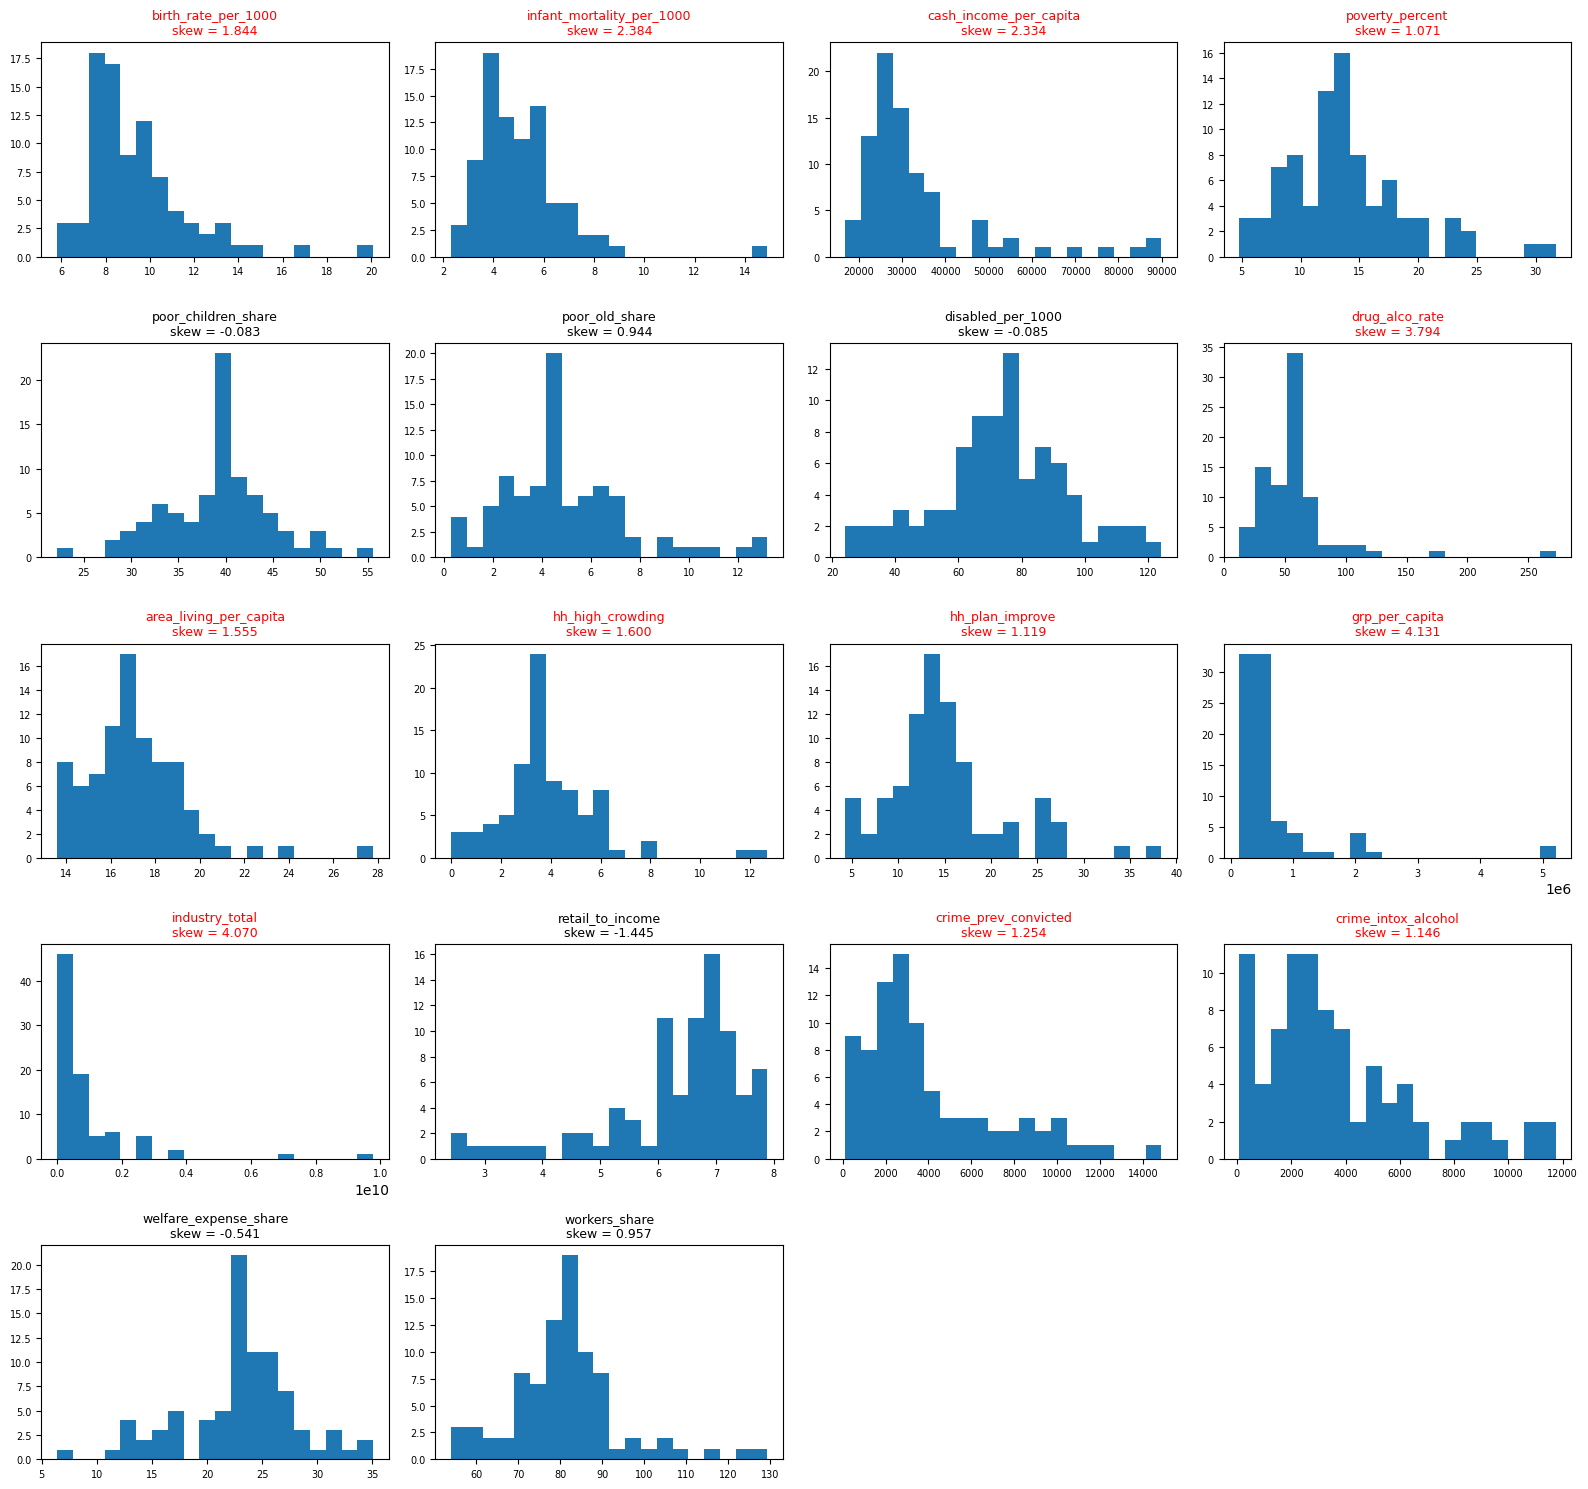

In [7]:
def analyze_skew(df, features):
    """
    Анализ скошенности распределений:
    - строит гистограммы
    - выделяет красным сильно скошенные признаки (skew > 1)
    - собирает их в список log_features
    - возвращает log_features
    """

    # Таблица с наличием сдвигов
    skew_table = (df[features].skew().to_frame(name="skew").sort_values("skew", ascending=False))

    log_features = []

    fig, axes = plt.subplots(5, 4, figsize=(16, 15))
    axes = axes.flatten()

    for i, col in enumerate(features):
        # Гистограмма
        axes[i].hist(df[col], bins=20)

        # Значение сдвига в заголовок
        skew_value = df[col].skew()

        if skew_value > 1:
            title_color = "red"
            log_features.append(col)
        else:
            title_color = "black"

        axes[i].set_title(f"{col}\nskew = {skew_value:.3f}", fontsize=9, color=title_color)

        axes[i].tick_params(axis="both", labelsize=7)

    # Выключаем лишние оси
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    return log_features
    
log_features = analyze_skew(df_model, features_final)

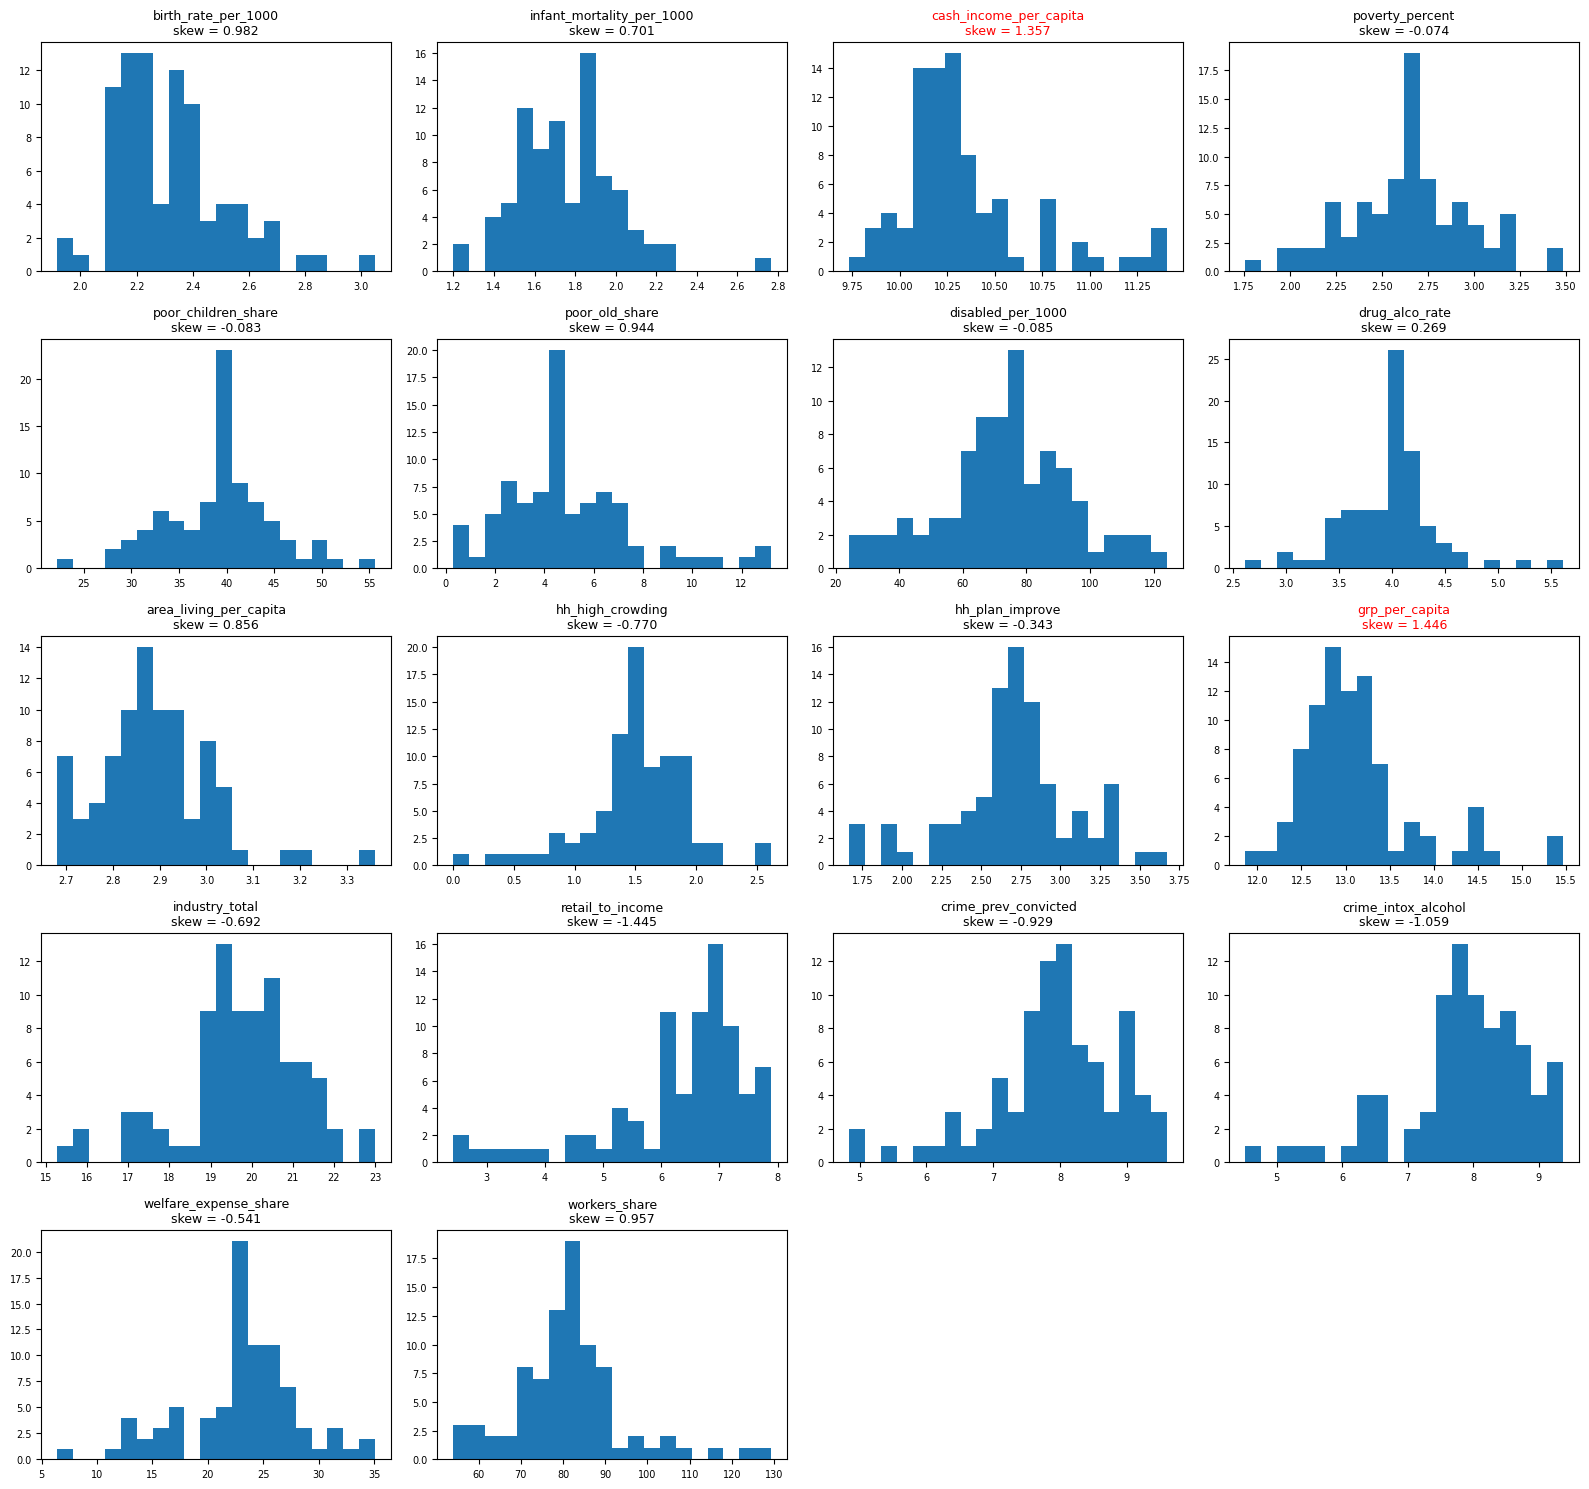

In [8]:
# Все признаки, которые нужно логарифмировать (skew > 1)
for col in log_features:
    df_model[col] = np.log1p(df_model[col])
    
log_features = analyze_skew(df_model, features_final)

После преобразования значения скошенности существенно снизились и находятся в допустимых пределах для применения методов снижения размерности и кластеризации. 

### 3. Масштабирование признаков.

Итоговый набор признаков включает показатели, измеряемые в разных единицах (рубли, проценты, показатели на 1000 человек и т. д.) и существенно отличающиеся по диапазону значений.  
Методы главных компонент (PCA) и алгоритмы кластеризации (в частности, KMeans) чувствительны к масштабу признаков, так как опираются на расстояния между наблюдениями.
 Чтобы обеспечить сопоставимый вклад переменных в формирование расстояний и главных компонент, все признаки стандартизируем.


In [9]:
X = df_model[features_final].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 4. Кластеризация.

Для сопоставления качества различных моделей кластеризации (k-means на исходном пространстве признаков, k-means на PCA-признаках, иерархическая кластеризация и т.д.) удобно вести сводную таблицу с основными метриками качества.

Ниже определим вспомогательную функцию для вычисления метрик и добавления строки в общую таблицу результатов. 

In [10]:
# Общий список для хранения результатов разных моделей кластеризации
clustering_results = []

def add_clustering_metrics(model_name, data_space, X, labels, k=None):
    """
    Вычисляет метрики кластеризации и добавляет строку в общий список результатов.
    
    Параметры:
    - model_name: строка, название модели.
    - data_space: строка, описание пространства признаков.
    - X: матрица признаков, по которой проводилась кластеризация.
    - labels: метки кластеров (массив).
    - k: число кластеров.
    """
    silhouette = metrics.silhouette_score(X, labels)
    calinski_harabasz = metrics.calinski_harabasz_score(X, labels)
    davies_bouldin = metrics.davies_bouldin_score(X, labels)
    
    result = {"model": model_name,
              "data_space": data_space,
              "k": k,
              "silhouette": silhouette,
              "calinski_harabasz": calinski_harabasz,
              "davies_bouldin": davies_bouldin
             }
    
    clustering_results.append(result)

#### 4.1. Выбор числа кластеров.

Перед применением алгоритма k-means необходимо определить разумное количество кластеров (k). Для этого используются:

1. **Метод локтя** (Elbow method).
    Точка излома графика («локоть») рассматривается как кандидат на оптимальное число кластеров.

3. **Коэффициент силуэта** (Silhouette Score).
    Значения, при которых силуэт максимален (пик), рассматривается как кандидат на оптимальное число кластеров.

4. **Индекс Калински-Харабаса** (Calinski-Harabasz score).
    Чем выше значение, тем более качественной считается кластеризация.

5. **Индекс Дэвиса-Болдина** (Davies-Bouldin score).
    Чем ниже показатель, тем лучше (0 - идеальные кластеры).   

Использование набора метрик позволяет избежать решения, основанного только на одном критерии, и обеспечивает более устойчивый выбор оптимального числа кластеров.

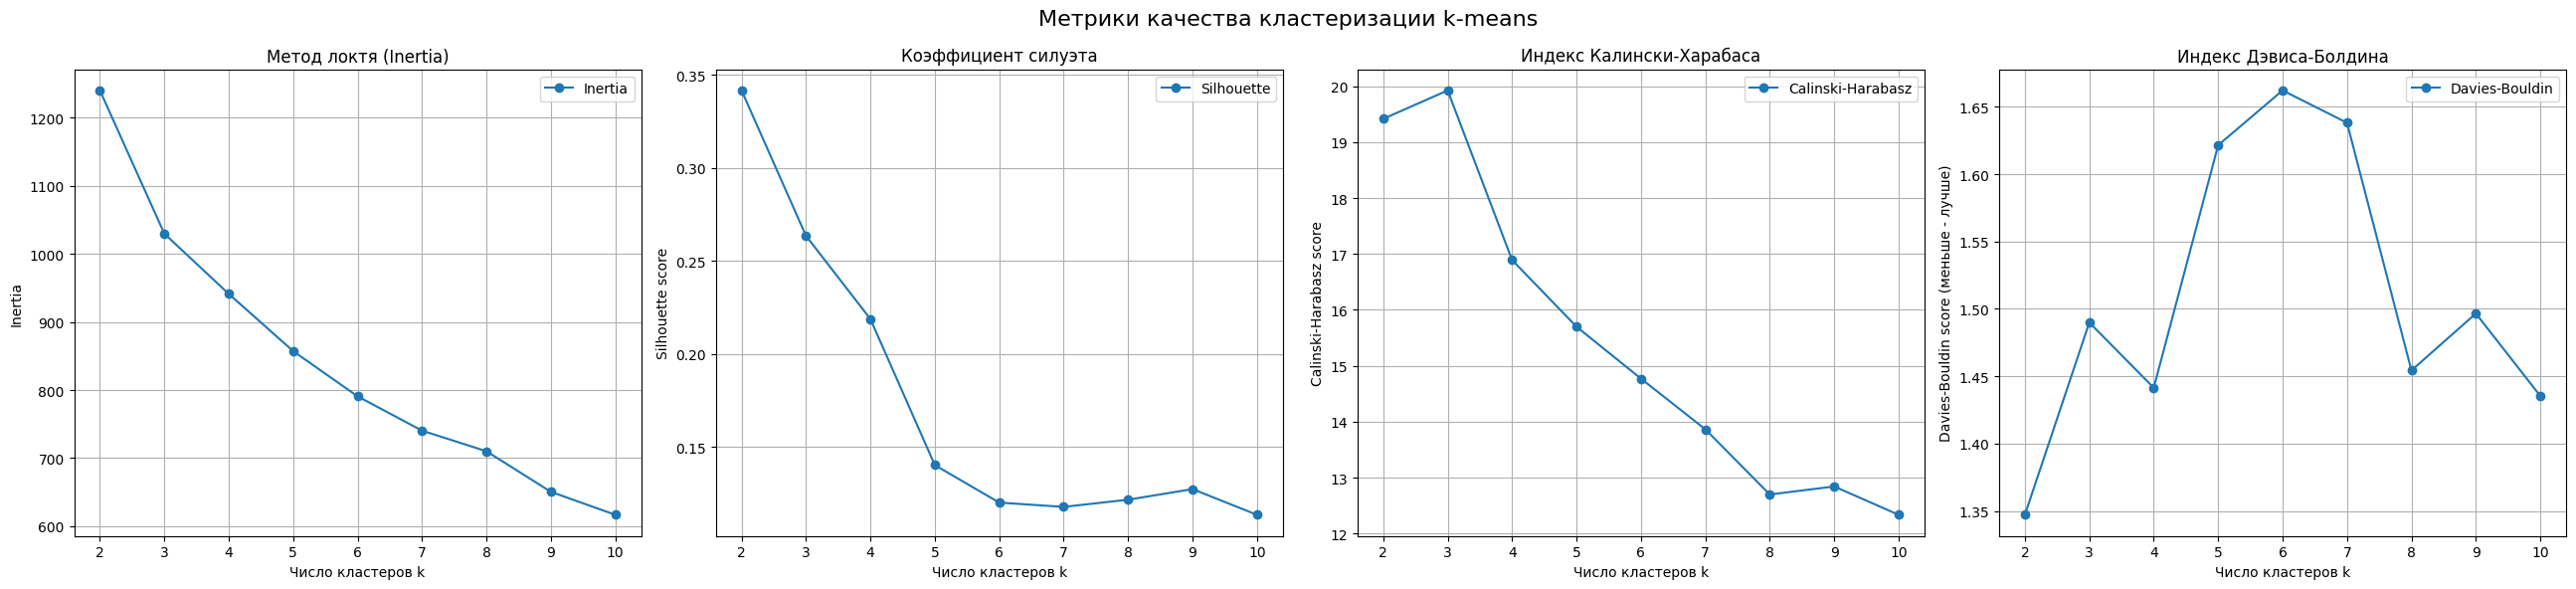

,k,inertia,silhouette,calinski_harabasz,davies_bouldin
0,2,1239.952093,0.341725,19.415247,1.347230
1,3,1029.662581,0.263558,19.922870,1.489924
2,4,941.175652,0.218799,16.891913,1.441460
3,5,857.138351,0.140253,15.700188,1.621502
4,6,790.719767,0.120095,14.772146,1.662147
5,7,740.356504,0.117795,13.865436,1.638145
6,8,710.094902,0.121657,12.701057,1.454350
7,9,650.506402,0.127345,12.844131,1.496589
8,10,616.786453,0.113548,12.338327,1.435437


In [11]:
def plot_kmeans_metrics(X, k_min=2, k_max=11):
    """
    Рисует метрики кластеризации k-means.
    
    Метрики:
    - inertia (локоть)
    - silhouette score (силуэт)
    - Calinski-Harabasz score
    - Davies-Bouldin score
    """

    inertia = []
    silhouette = []
    calinski_harabasz = []
    davies_bouldin = []

    ks = range(k_min, k_max)

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        # Метрики
        inertia.append(kmeans.inertia_)
        silhouette.append(metrics.silhouette_score(X, labels))
        calinski_harabasz.append(metrics.calinski_harabasz_score(X, labels))
        davies_bouldin.append(metrics.davies_bouldin_score(X, labels))
    
    metrics_df = pd.DataFrame({"k": list(ks),
                               "inertia": inertia,
                               "silhouette": silhouette,
                               "calinski_harabasz": calinski_harabasz,
                               "davies_bouldin": davies_bouldin
                              })
    # Рисуем графики
    fig, ax = plt.subplots(1, 4, figsize=(26, 6))

    ax[0].plot(ks, inertia, 'o-', label='Inertia')
    ax[0].set_title("Метод локтя (Inertia)")
    ax[0].set_xlabel("Число кластеров k")
    ax[0].set_ylabel("Inertia")

    ax[1].plot(ks, silhouette, 'o-', label='Silhouette')
    ax[1].set_title("Коэффициент силуэта")
    ax[1].set_xlabel("Число кластеров k")
    ax[1].set_ylabel("Silhouette score")

    ax[2].plot(ks, calinski_harabasz, 'o-', label='Calinski-Harabasz')
    ax[2].set_title("Индекс Калински-Харабаса")
    ax[2].set_xlabel("Число кластеров k")
    ax[2].set_ylabel("Calinski-Harabasz score")

    ax[3].plot(ks, davies_bouldin, 'o-', label='Davies-Bouldin')
    ax[3].set_title("Индекс Дэвиса-Болдина")
    ax[3].set_xlabel("Число кластеров k")
    ax[3].set_ylabel("Davies-Bouldin score (меньше - лучше)")

    for i in range(4):
        ax[i].grid(True)
        ax[i].legend()

    fig.suptitle("Метрики качества кластеризации k-means", fontsize=16)
    fig.tight_layout()
    plt.show()
    
    return metrics_df

metrics_table = plot_kmeans_metrics(X_scaled)
display(metrics_table)

Анализ метрик качества показал, что:

- при увеличении числа кластеров значение inertia монотонно уменьшается, при этом наиболее заметное снижение наблюдается при переходе от k = 2 к k = 3, после чего темп убывания становится более плавным (характерный «локоть» графика в области k 3-4);
- максимальное значение коэффициента силуэта достигается при k = 2, что отражает наиболее чёткое разделение выборки на две крупные группы регионов; при k = 3 силуэт несколько снижается, однако остаётся на приемлемом уровне;
- индекс Калински-Харабаса принимает наибольшее значение при k = 3, что свидетельствует о хорошем соотношении межкластерной и внутрикластерной дисперсии именно для трёхкластерного решения;
- индекс Дэвиса-Болдина минимален при k = 2, однако для k = 3 его значение лишь незначительно ухудшается.

Таким образом, с точки зрения метрик возможны как двухкластерное, так и трёхкластерное разбиения.  
При этом решение с k = 2 даёт более грубую структуру (разделение регионов на две очень крупные группы), тогда как вариант с k = 3 позволяет получить более детализированную и содержательно интерпретируемую типологию регионов (условно: уязвимые, средние и относительно благополучные регионы).

В дальнейшем в качестве основного решения для анализа и интерпретации используется кластеризация с **k = 3**.

#### 4.2. Кластеризация k-means (baseline).


In [12]:
kmeans_base = KMeans(n_clusters=3, random_state=42, n_init=10)

cluster_labels_base = kmeans_base.fit_predict(X_scaled)

df_model["kmeans"] = cluster_labels_base

# Добавляем метрики модели в общую таблицу
add_clustering_metrics(model_name="kmeans",
                       data_space="X_scaled",
                       X=X_scaled,
                       labels=cluster_labels_base,
                       k=3)

Визуализируем результат в пространстве главных компонент (PCA).
Каждая точка - это регион России, а цвет соответствует кластеру, полученному при k-means с 3 кластерами.

Помимо линейного метода главных компонент (PCA), для анализа структуры данных используем еще t-SNE. Он позволяет наглядно увидеть, насколько явно выделяются кластеры, полученные алгоритмом k-means, и есть ли «переходные» регионы между ними.

In [13]:
def plot_pca_tsne(X, labels, title_suffix=""):
    """
    Строит два графика рядом для заданной кластеризации:
    слева - проекция на первые две главные компоненты (PCA),
    справа - проекция t-SNE.
    
    Параметры:
    - X: матрица признаков
    - labels: метки кластеров
    - title_suffix: текст для заголовков
    """
    
    labels = np.asarray(labels)
    
    # PCA 
    pca_2 = PCA(n_components=2, random_state=42)
    X_pca_2 = pca_2.fit_transform(X)
    
    # t-SNE 
    tsne = TSNE(n_components=2,
                perplexity=15,
                max_iter=1000,
                random_state=42,
                init="pca"
                )
    X_tsne_2 = tsne.fit_transform(X)
    
    # Рисуем графики
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # PCA
    sc1 = axes[0].scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels)
    axes[0].set_title(f"PCA - {title_suffix}")
    axes[0].set_xlabel("PC1")
    axes[0].set_ylabel("PC2")
    axes[0].grid(True)
    
    # t-SNE
    sc2 = axes[1].scatter(X_tsne_2[:, 0], X_tsne_2[:, 1], c=labels)
    axes[1].set_title(f"t-SNE - {title_suffix}")
    axes[1].set_xlabel("t-SNE 1")
    axes[1].set_ylabel("t-SNE 2")
    axes[1].grid(True)
    
    # Легенда
    handles, _ = sc1.legend_elements(prop="colors")
    unique_labels = sorted(np.unique(labels))
    fig.legend( handles,
               [f"Кластер {i}" for i in unique_labels],
               title="Кластеры",
               loc="lower center",
               ncol=len(unique_labels)
              )
    
    plt.tight_layout()
    plt.show()

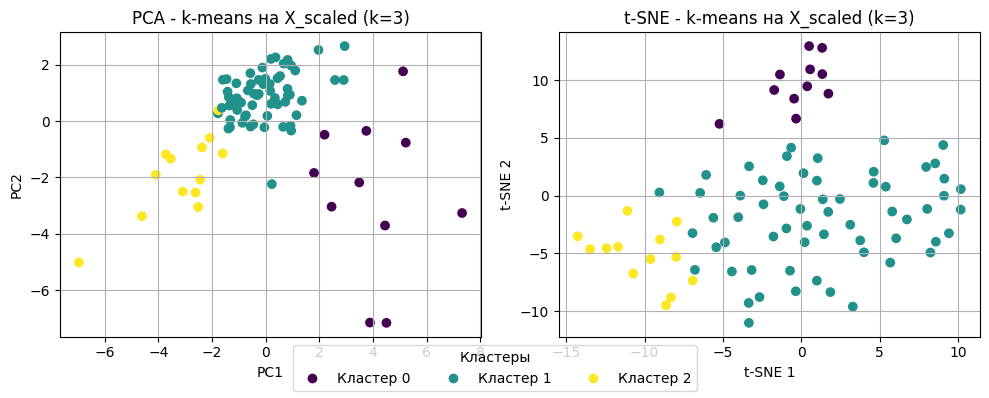

In [14]:
plot_pca_tsne(X=X_scaled,
              labels=cluster_labels_base,
              title_suffix="k-means на X_scaled (k=3)")

На графике PCA заметно, что кластеры имеют различимую структуру и занимают разные зоны в пространстве главных компонент:

- **Кластер 1** (бирюзовый) формирует компактную и плотную группу.  
  Это указывает на высокую степень сходства регионов внутри кластера по всем ключевым социально-экономическим показателям.

- **Кластер 2** (жёлтый) имеет вытянутую форму вдоль оси PC1.  
  Это говорит о том, что внутри кластера регионы отличаются по одному или нескольким признакам, но сохраняют общую направленность.

- **Кластер 0** (фиолетовый) находится обособленно и занимает отдельную область пространства.  
  Такие регионы статистически выделяются от остальных по совокупности признаков - либо более благополучные, либо имеющие ярко выраженные социально-экономические особенности.

В целом визуализация подтверждает, что выбранное число кластеров отражает реальные различия между группами регионов. Кластеры имеют чёткие границы и не смешиваются хаотически, что говорит о стабильности результатов кластеризации.

На t-SNE-графике видно, что кластеры в целом образуют отдельные группы в двумерном пространстве.
- Один из кластеров формирует компактное облако точек, что говорит о высокой однородности регионов внутри этой группы.
- Другой кластер растянут сильнее, что отражает наличие более выраженных внутренних различий между входящими в него регионами.
- Третий кластер располагается в стороне от остальных и также сохраняет относительную целостность.

Несмотря на то, что глобальная форма и взаимное расположение кластеров в проекции t-SNE отличаются от картины в пространстве PC1-PC2 (что ожидаемо для нелинейного метода), оба подхода подтверждают наличие трёх достаточно устойчивых групп регионов.

#### 4.3. K-means на PCA-признаках. 

Помимо кластеризации в исходном стандартизованном пространстве признаков, имеет смысл проверить качество кластеризации в пространстве главных компонент.  

Сначала найдём минимальное число компонент, которые суммарно объясняют не менее 90 % разброса данных, затем выполним кластеризацию k-means в этом пространстве и сравним её качество с базовой моделью k-means на стандартизованных признаках.


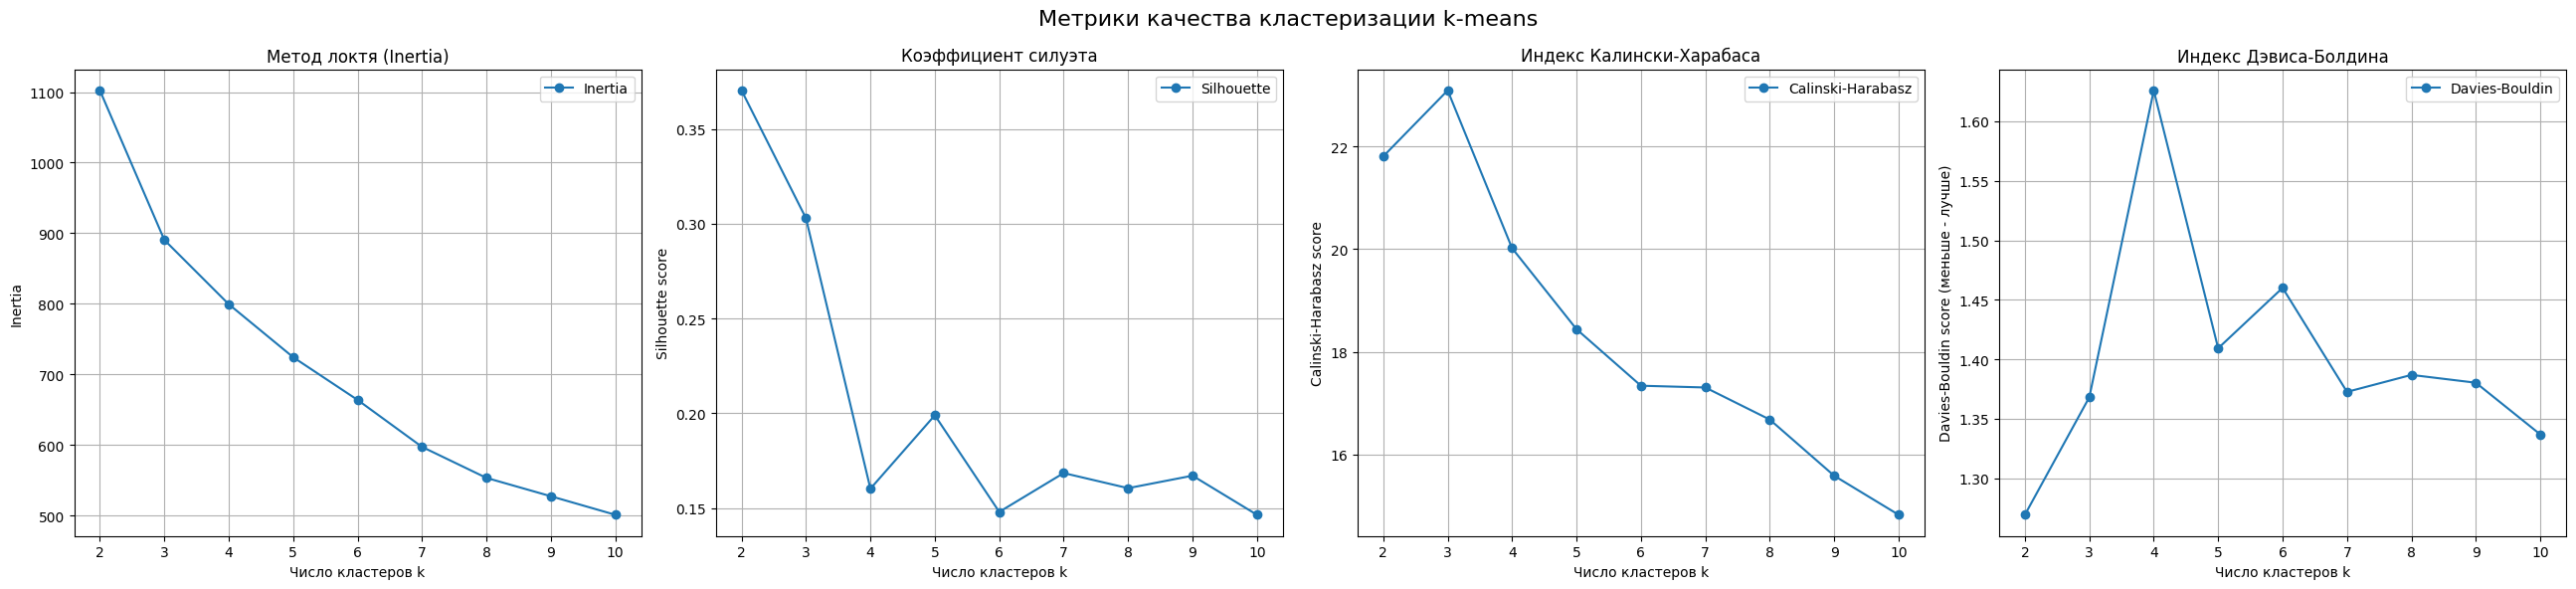

,k,inertia,silhouette,calinski_harabasz,davies_bouldin
0,2,1102.395774,0.370395,21.805324,1.269349
1,3,890.505661,0.302933,23.089955,1.368138
2,4,799.375365,0.160252,20.017096,1.625988
3,5,724.253374,0.198989,18.439901,1.409292
4,6,663.686598,0.148006,17.338804,1.460058
5,7,597.148795,0.168501,17.304253,1.372645
6,8,553.195950,0.160532,16.679388,1.386907
7,9,527.175135,0.167119,15.584848,1.380325
8,10,500.901834,0.146492,14.825087,1.336874


In [15]:
pca = PCA(n_components=0.9, random_state=42)
X_pca = pca.fit_transform(X_scaled)

metrics_table_pca = plot_kmeans_metrics(X_pca)
display(metrics_table_pca)

Здесь так же выбираем количество кластеров - 3.

In [16]:
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)

cluster_labels_pca = kmeans_pca.fit_predict(X_pca)

df_model["kmeans_pca"] = cluster_labels_pca

# Добавляем метрики этой модели в общую таблицу результатов
add_clustering_metrics(model_name="kmeans_pca",
                       data_space="X_pca",
                       X=X_pca,
                       labels=cluster_labels_pca,
                       k=3)

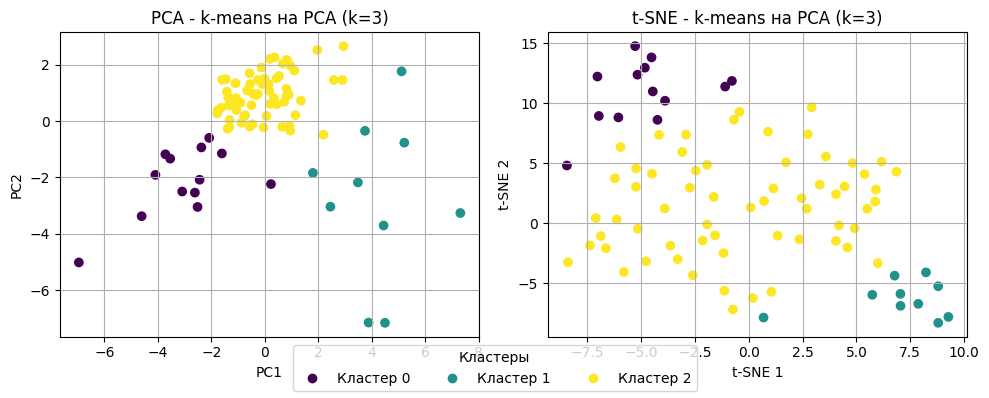

In [17]:
plot_pca_tsne(X=X_pca,
              labels=cluster_labels_pca,
              title_suffix="k-means на PCA (k=3)")

In [18]:
# Сводная таблица метрик кластеризации
clustering_results_df = pd.DataFrame(clustering_results)
display(clustering_results_df)

,model,data_space,k,silhouette,calinski_harabasz,davies_bouldin
0,kmeans,X_scaled,3,0.263558,19.922870,1.489924
1,kmeans_pca,X_pca,3,0.302933,23.089955,1.368138


Результаты стали лучше. K-means на PCA-признаках даёт более чёткую и устойчивую кластеризацию, чем базовая модель на X_scaled.

#### 4.4. Иерархическая кластеризация (Agglomerative).

Используем данные после PCA-преобразования: массив X_pca. Количество кластеров оставляем равным 3.

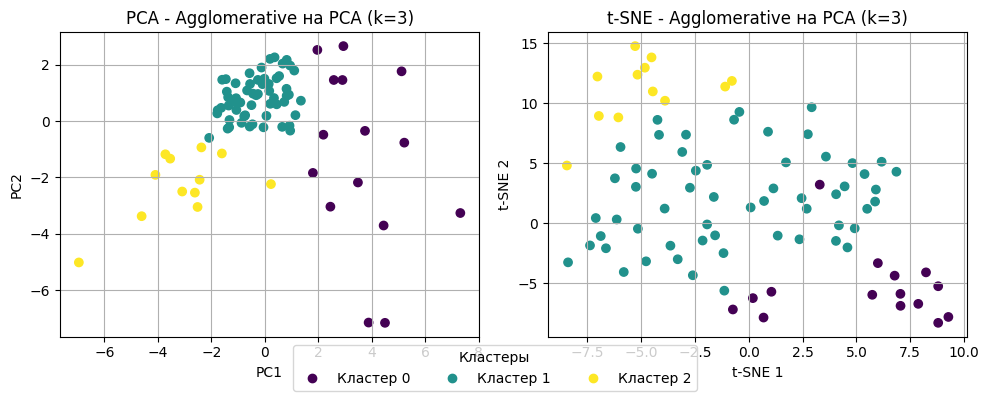

In [19]:
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")

cluster_labels_agg = agg.fit_predict(X_pca)
df_model["agglomerative_pca"] = cluster_labels_agg

add_clustering_metrics(model_name="agglomerative_pca",
                       data_space="X_pca",
                       X=X_pca,
                       labels=cluster_labels_agg,    
                       k=3)

plot_pca_tsne(X=X_pca, 
              labels=cluster_labels_agg,
              title_suffix="Agglomerative на PCA (k=3)")

#### 4.4. EM-алгоритм (GaussianMixture).

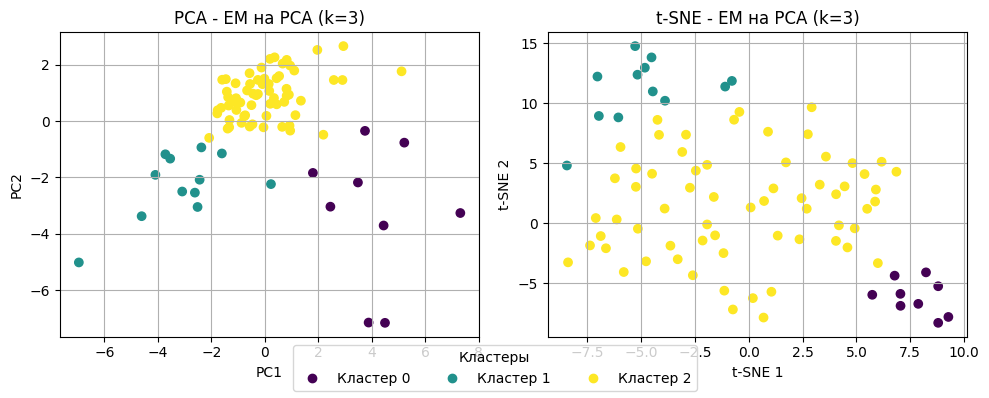

In [20]:
gmm = GaussianMixture(n_components=3, covariance_type='tied', random_state=42) 
gmm.fit(X_pca)
cluster_labels_gmm = gmm.predict(X_pca)
df_model["gmm_pca"] = cluster_labels_gmm

add_clustering_metrics(model_name="gmm_pca",
                       data_space="X_pca",
                       X=X_pca,
                       labels=cluster_labels_gmm,
                       k=3)

plot_pca_tsne(X=X_pca,
              labels=cluster_labels_gmm,
              title_suffix="EM на PCA (k=3)")

#### 4.5. Спектральная кластеризация.

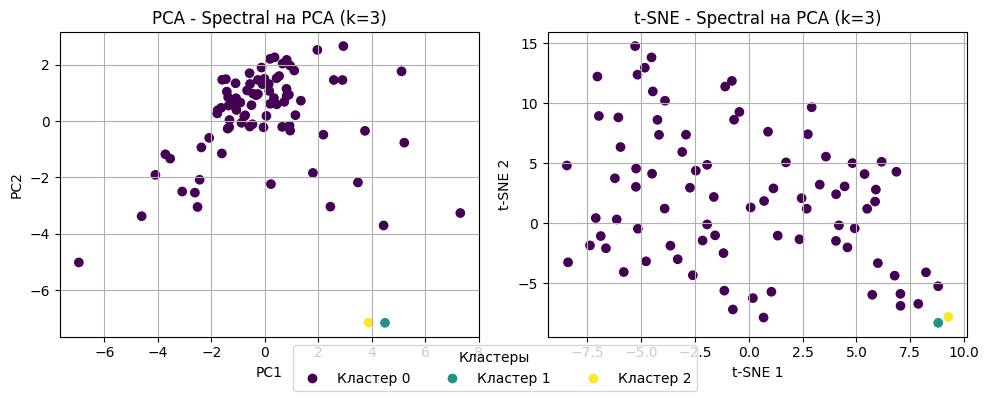

In [21]:
spectral = SpectralClustering(n_clusters=3,
                              affinity="rbf", 
                              assign_labels="kmeans",
                              random_state=42)
cluster_labels_spectral = spectral.fit_predict(X_pca)
df_model["spectral_pca"] = cluster_labels_spectral

add_clustering_metrics(model_name="spectral_pca",
                       data_space="X_pca",
                       X=X_pca,
                       labels=cluster_labels_spectral,
                       k=3)

plot_pca_tsne(X=X_pca,
              labels=cluster_labels_spectral,
              title_suffix="Spectral на PCA (k=3)")

#### 4.6. DBSCAN.

In [22]:
# Подберем параметры
siliuette_list_dbscan = []
 
for eps in np.arange(0.1,3,0.2):
    for min_sample in range(2,20,4):
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(X_pca)
        # считаем количество "настоящих" кластеров (без шума -1)
        labels = dbscan.labels_
        
        unique_labels = set(labels)
        n_clusters = len(unique_labels - {-1})
        
        # если меньше двух кластеров - силуэт посчитать нельзя
        if n_clusters < 2:
            sil_score = np.nan
        else:
            sil_score = silhouette_score(X_pca, labels, metric="euclidean")
        
        siliuette_list_dbscan.append(
            (eps, min_sample, sil_score, n_clusters)
        )
        
df_dbscan = pd.DataFrame(siliuette_list_dbscan, columns=['eps', 'min_samples', 'sil_score', 'number_of_clusters'])
df_dbscan.sort_values(by = 'sil_score', ascending=False).head(3)

,eps,min_samples,sil_score,number_of_clusters
65,2.7,2,0.130037,2
70,2.9,2,0.108674,3
60,2.5,2,0.045700,2


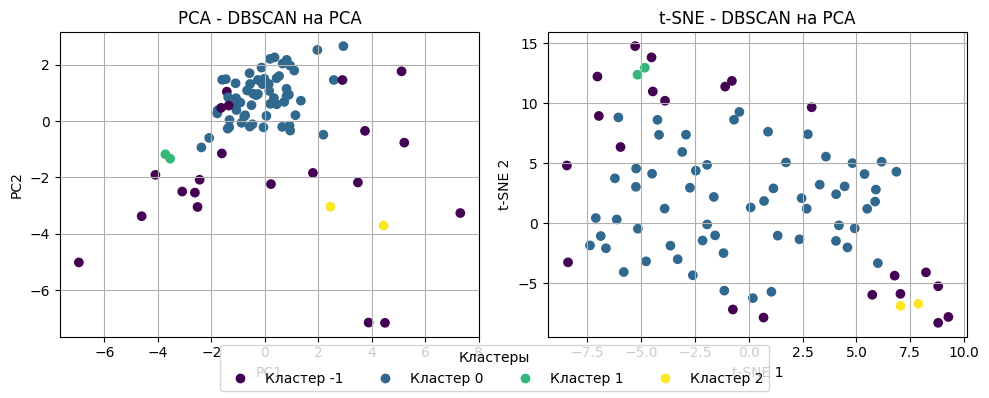

In [23]:
db_best = DBSCAN(eps=2.9, min_samples=2)
cluster_labels_dbscan = db_best.fit_predict(X_pca)

df_model["dbscan_pca"] = cluster_labels_dbscan

add_clustering_metrics(
    model_name="dbscan_pca",
    data_space="X_pca",
    X=X_pca,
    labels=cluster_labels_dbscan,
    k=3)

plot_pca_tsne(X=X_pca,
              labels=cluster_labels_dbscan,
              title_suffix="DBSCAN на PCA")

#### 4.7. Итоги по кластеризации, выбор модели.

In [24]:
# Сводная таблица метрик кластеризации
clustering_results_df = pd.DataFrame(clustering_results)
display(clustering_results_df)

,model,data_space,k,silhouette,calinski_harabasz,davies_bouldin
0,kmeans,X_scaled,3,0.263558,19.922870,1.489924
1,kmeans_pca,X_pca,3,0.302933,23.089955,1.368138
2,agglomerative_pca,X_pca,3,0.276156,21.143545,1.469220
3,gmm_pca,X_pca,3,0.313465,22.703473,1.327231
4,spectral_pca,X_pca,3,0.478331,6.130413,0.363773
5,dbscan_pca,X_pca,3,0.108674,5.018093,2.309344


In [25]:
# Посмотрим на структуру
for col in ['kmeans', 'kmeans_pca', 'agglomerative_pca', 'gmm_pca', 'spectral_pca', 'dbscan_pca']:
    if col in df_model.columns:
        print(df_model[col].value_counts().sort_index(), "\n")

kmeans
0    11
1    61
2    13
Name: count, dtype: int64 

kmeans_pca
0    13
1    10
2    62
Name: count, dtype: int64 

agglomerative_pca
0    15
1    58
2    12
Name: count, dtype: int64 

gmm_pca
0     9
1    12
2    64
Name: count, dtype: int64 

spectral_pca
0    83
1     1
2     1
Name: count, dtype: int64 

dbscan_pca
-1    21
 0    60
 1     2
 2     2
Name: count, dtype: int64 



Несмотря на то, что спектральная кластеризация в пространстве главных компонент продемонстрировала лучшие значения метрик силуэта и индекса Дэвиса-Болдина, однако анализ распределения объектов по кластерам и визуальный анализ t-SNE и PCA-проекций показал, что алгоритм формирует один доминирующий кластер и несколько очень малочисленных групп. Такая структура кластеров плохо поддаётся интерпретации и не отражает реальных различий между регионами.

Наилучшие значения достигаются для моделей k-means и GMM в пространстве PCA-признаков. Для последующего анализа была выбрана модель k-means на данных после PCA, обеспечивающая более устойчивую, сбалансированную и интерпретируемую кластеризацию.

In [26]:
# Фиксируем рабочую таблицу
cluster_col = "kmeans_pca"

clust_cols_to_drop = ["kmeans", 
                      "agglomerative_pca",
                      "gmm_pca",
                      "spectral_pca",
                      "dbscan_pca"]

df_work = df_model.drop(columns=clust_cols_to_drop).copy()
df_work = df_work.rename(columns={cluster_col: "cluster"})

### 5. Интерпретация кластеров.

В этом разделе интерпретируем результаты кластеризации регионов по социально-экономическим показателям за 2020 год. Используя разбиение на три кластера, полученное на основе 18 количественных признаков, сравним типичные профили кластеров, опишем их социально-экономические особенности и попробуем выделить группы регионов, требующих приоритетной поддержки или, наоборот, выступающих «точками роста». Для наглядности представим профиль кластеров в виде полярной диаграммы (Radar Chart) и сформулируем выводы.

#### 5.1. Подготовка данных для интерпретации.

In [27]:
# Определим смысловые блоки признаков
blocks = {
    # Демография
    "demography": [
        "birth_rate_per_1000",        # коэффициент рождаемости на 1000 человек
        "infant_mortality_per_1000"  # младенческая смертность: умершие до 1 года на 1000 рождений
    ],

    # Бедность и доходы
    "poverty": [
        "poverty_percent",        # доля населения с доходами ниже прожиточного минимума
        "poor_children_share",    # доля детей (0-16 лет) среди малоимущих
        "poor_old_share",         # доля пенсионеров среди малоимущих
        "cash_income_per_capita" # среднедушевые денежные доходы населения
    ],

    # Здоровье и социальная уязвимость
    "health_social": [
        "disabled_per_1000",  # инвалидность на 1000 населения
        "drug_alco_rate"     # впервые зарегистрированные случаи алкоголизма/наркоманий на 100 000 населения
    ],

    # Жилищные условия
    "housing": [
        "area_living_per_capita", # жилая площадь на 1 человека, кв.м
        "hh_high_crowding",       # доля домохозяйств с сильной стеснённостью, %
        "hh_plan_improve"        # доля домохозяйств, желающих улучшить жилищные условия
    ],

    # Экономическое развитие и промышленность
    "economy_industry": [
        "grp_per_capita",   # валовой региональный продукт на душу населения
        "industry_total"   # общий объём промышленного производства
    ],

    # Потребление и розничная торговля
    "consumption": [
        "retail_to_income"  # отношение розничного оборота к доходам населения
    ],

    # Занятость
    "employment": [
        "workers_share"  # доля занятых среди населения трудоспособного возраста
    ],

    # Преступность
    "crime": [
        "crime_prev_convicted",  # преступления ранее судимых
        "crime_intox_alcohol"   # преступления в состоянии алкогольного опьянения
    ],

    # Социальная политика
    "social_policy": [
        "welfare_expense_share" # доля расходов на социальную политику в бюджете региона
    ]
}


#### 5.2. Общая характеристика кластеров.

Посмотрим по каждому кластеру список первых 10 регионов, чтобы понять, кто туда попал.

In [28]:
# Список регионов по кластерам
regions_by_cluster = (df_work.groupby("cluster")["region"].apply(list).sort_index())

for cl, regs in regions_by_cluster.items():
    print(f"\nКластер {cl} - всего {len(regs)} регионов:")
    print(", ".join(regs[:10]), ("и др." if len(regs) > 10 else ""))


Кластер 0 - всего 13 регионов:
Еврейская автономная область, Кабардино-Балкарская Республика, Карачаево-Черкесская Республика, Республика Адыгея, Республика Алтай, Республика Дагестан, Республика Ингушетия, Республика Калмыкия, Республика Марий Эл, Республика Северная Осетия-Алания и др.

Кластер 1 - всего 10 регионов:
Камчатский край, Магаданская область, Ненецкий автономный округ, Республика Саха (Якутия), Сахалинская область, Тюменская область, Ханты-Мансийский автономный округ, Чукотский автономный округ, Ямало-Ненецкий автономный округ, г. Москва 

Кластер 2 - всего 62 регионов:
Алтайский край, Амурская область, Архангельская область, Астраханская область, Белгородская область, Брянская область, Владимирская область, Волгоградская область, Вологодская область, Воронежская область и др.


Теперь посмотрим на средние значения по основным показателям бедности и уязвимости в разрезе кластеров.

In [29]:
poverty_cols = ["poverty_percent",
                "poor_children_share",
                "poor_old_share",
                "cash_income_per_capita"]

cluster_poverty_profile = (df_work.groupby("cluster")[poverty_cols].mean().round(2))
display(cluster_poverty_profile)

,poverty_percent,poor_children_share,poor_old_share,cash_income_per_capita
cluster,,,,
0,3.04,37.95,5.74,10.04
1,2.31,43.50,4.95,11.10
2,2.61,38.74,4.77,10.28


Анализ показателей, характеризующих структуру бедного населения (доля детей и доля пожилых среди малоимущих), показал следующее:

- В кластере 0 наибольшая нагрузка бедности приходится одновременно на детей и пожилых, что говорит о комплексной межпоколенной уязвимости домохозяйств.
- В кластере 1 общий уровень бедности ниже, однако доля детей среди бедных максимальна, что указывает на риски детской бедности даже в экономически благополучных регионах.
- В кластере 2 значения долей бедных детей и пожилых близки к средним, при этом в отдельных регионах наблюдаются высокие значения этих показателей, что требует адресной поддержки конкретных групп населения.

Таким образом, **ключевыми группами риска в бедности выступают семьи с детьми и пожилые**, причём в разных кластерах их роль различается: в уязвимых регионах (кластер 0) бедность затрагивает несколько поколений одновременно, а в экономически сильных регионах (кластер 1) в большей степени концентрируется среди детей.

Посмотрим на средние значения всех признаков по кластерам.

In [30]:
# Средние значения всех признаков по кластерам
cluster_means = (df_work.groupby("cluster")[features_final].mean().round(2))
display(cluster_means)

,birth_rate_per_1000,infant_mortality_per_1000,cash_income_per_capita,poverty_percent,poor_children_share,poor_old_share,disabled_per_1000,drug_alco_rate,area_living_per_capita,hh_high_crowding,hh_plan_improve,grp_per_capita,industry_total,retail_to_income,crime_prev_convicted,crime_intox_alcohol,welfare_expense_share,workers_share
cluster,,,,,,,,,,,,,,,,,,
0,2.57,1.82,10.04,3.04,37.95,5.74,85.10,4.02,2.93,1.60,2.82,12.44,17.18,5.57,6.73,6.40,25.91,64.15
1,2.47,1.81,11.10,2.31,43.50,4.95,43.09,4.25,2.82,1.45,2.89,14.56,20.71,4.14,7.07,7.32,14.63,106.35
2,2.25,1.74,10.28,2.61,38.74,4.77,76.24,3.92,2.89,1.50,2.65,13.05,20.15,6.81,8.32,8.24,23.64,81.31


В кластер 0 попали преимущественно национальные республики, в кластер 1 - экономически развитые северные и сырьевые регионы вместе с Москвой, кластер 2 объединяет большинство «обычных» субъектов Федерации.

- **Кластер 0 (13 регионов)**  
  Характеризуется **самым высоким уровнем бедности** (в среднем около 3,0%), при этом денежные доходы населения на душу - самые низкие из трёх кластеров. Доля бедных детей и пожилых также остаётся высокой, особенно для пожилого населения. В сочетании с более низким уровнем экономического развития (меньший GRP на душу, более низкие показатели промышленного производства) это позволяет трактовать кластер 0 как группу социально и экономически уязвимых регионов, в которых проблема бедности носит хронический характер.

- **Кластер 1 (10 регионов)**  
  В эту группу попали преимущественно **богатые сырьевые регионы и Москва**. Здесь наблюдаются **наиболее высокие денежные доходы населения** (среднее значение показателя cash_income_per_capita - около 11,1) и **самый низкий средний уровень бедности** (примерно 2,3%). Вместе с тем доля бедных детей в этом кластере наибольшая среди трёх групп, что может свидетельствовать о сильной дифференциации доходов и наличии детской бедности даже на фоне в целом благополучных экономических условий. Доля бедных пожилых несколько ниже, а структура занятости и величина GRP на душу населения указывают на высокую экономическую активность.

- **Кластер 2 (62 региона)**  
  Самый многочисленный кластер, в который вошла основная масса регионов. По уровню доходов и бедности он занимает промежуточное положение: доходы выше, чем в кластере 0, но ниже, чем в кластере 1, уровень бедности находится между значениями кластеров 0 и 1. Доли бедных детей и пожилых также близки к среднероссийским. При этом по ряду показателей (в том числе по преступности и преступлениям в состоянии алкогольного опьянения) кластер 2 выглядит менее благополучно, чем богатый кластер 1, что отражает сочетание средних социально-экономических условий с более сложной социальной ситуацией в части девиантного поведения и безопасности.

В целом уже на этом этапе можно сделать несколько предварительных выводов важный для целей исследования.  
Кластер 0 можно рассматривать как группу **регионов с наиболее острой социально-экономической уязвимостью**, где требуется поддержка малоимущих домохозяйств и уязвимых групп населения, в первую очередь семей с детьми и пожилых.  
Кластер 1 - это **экономически благополучные регионы** с относительно низким уровнем бедности, но с рисками концентрации бедности среди детей, что требует более адресной социальной политики.  
Кластер 2 объединяет **«средние» регионы**, где уровень бедности близок к среднему по выборке, однако актуальны вопросы качества занятости, социальной инфраструктуры и профилактики девиантного поведения.

В дальнейшем более детальный анализ по блокам показателей (демография, доходы и бедность, жилищные условия, экономика, преступность, социальные расходы, занятость) и визуализация профилей кластеров на полярной диаграмме позволит уточнить социально-экономический портрет каждой группы регионов и более чётко сформулировать меры поддержки для разных типов территорий.


Построим графики распределений.

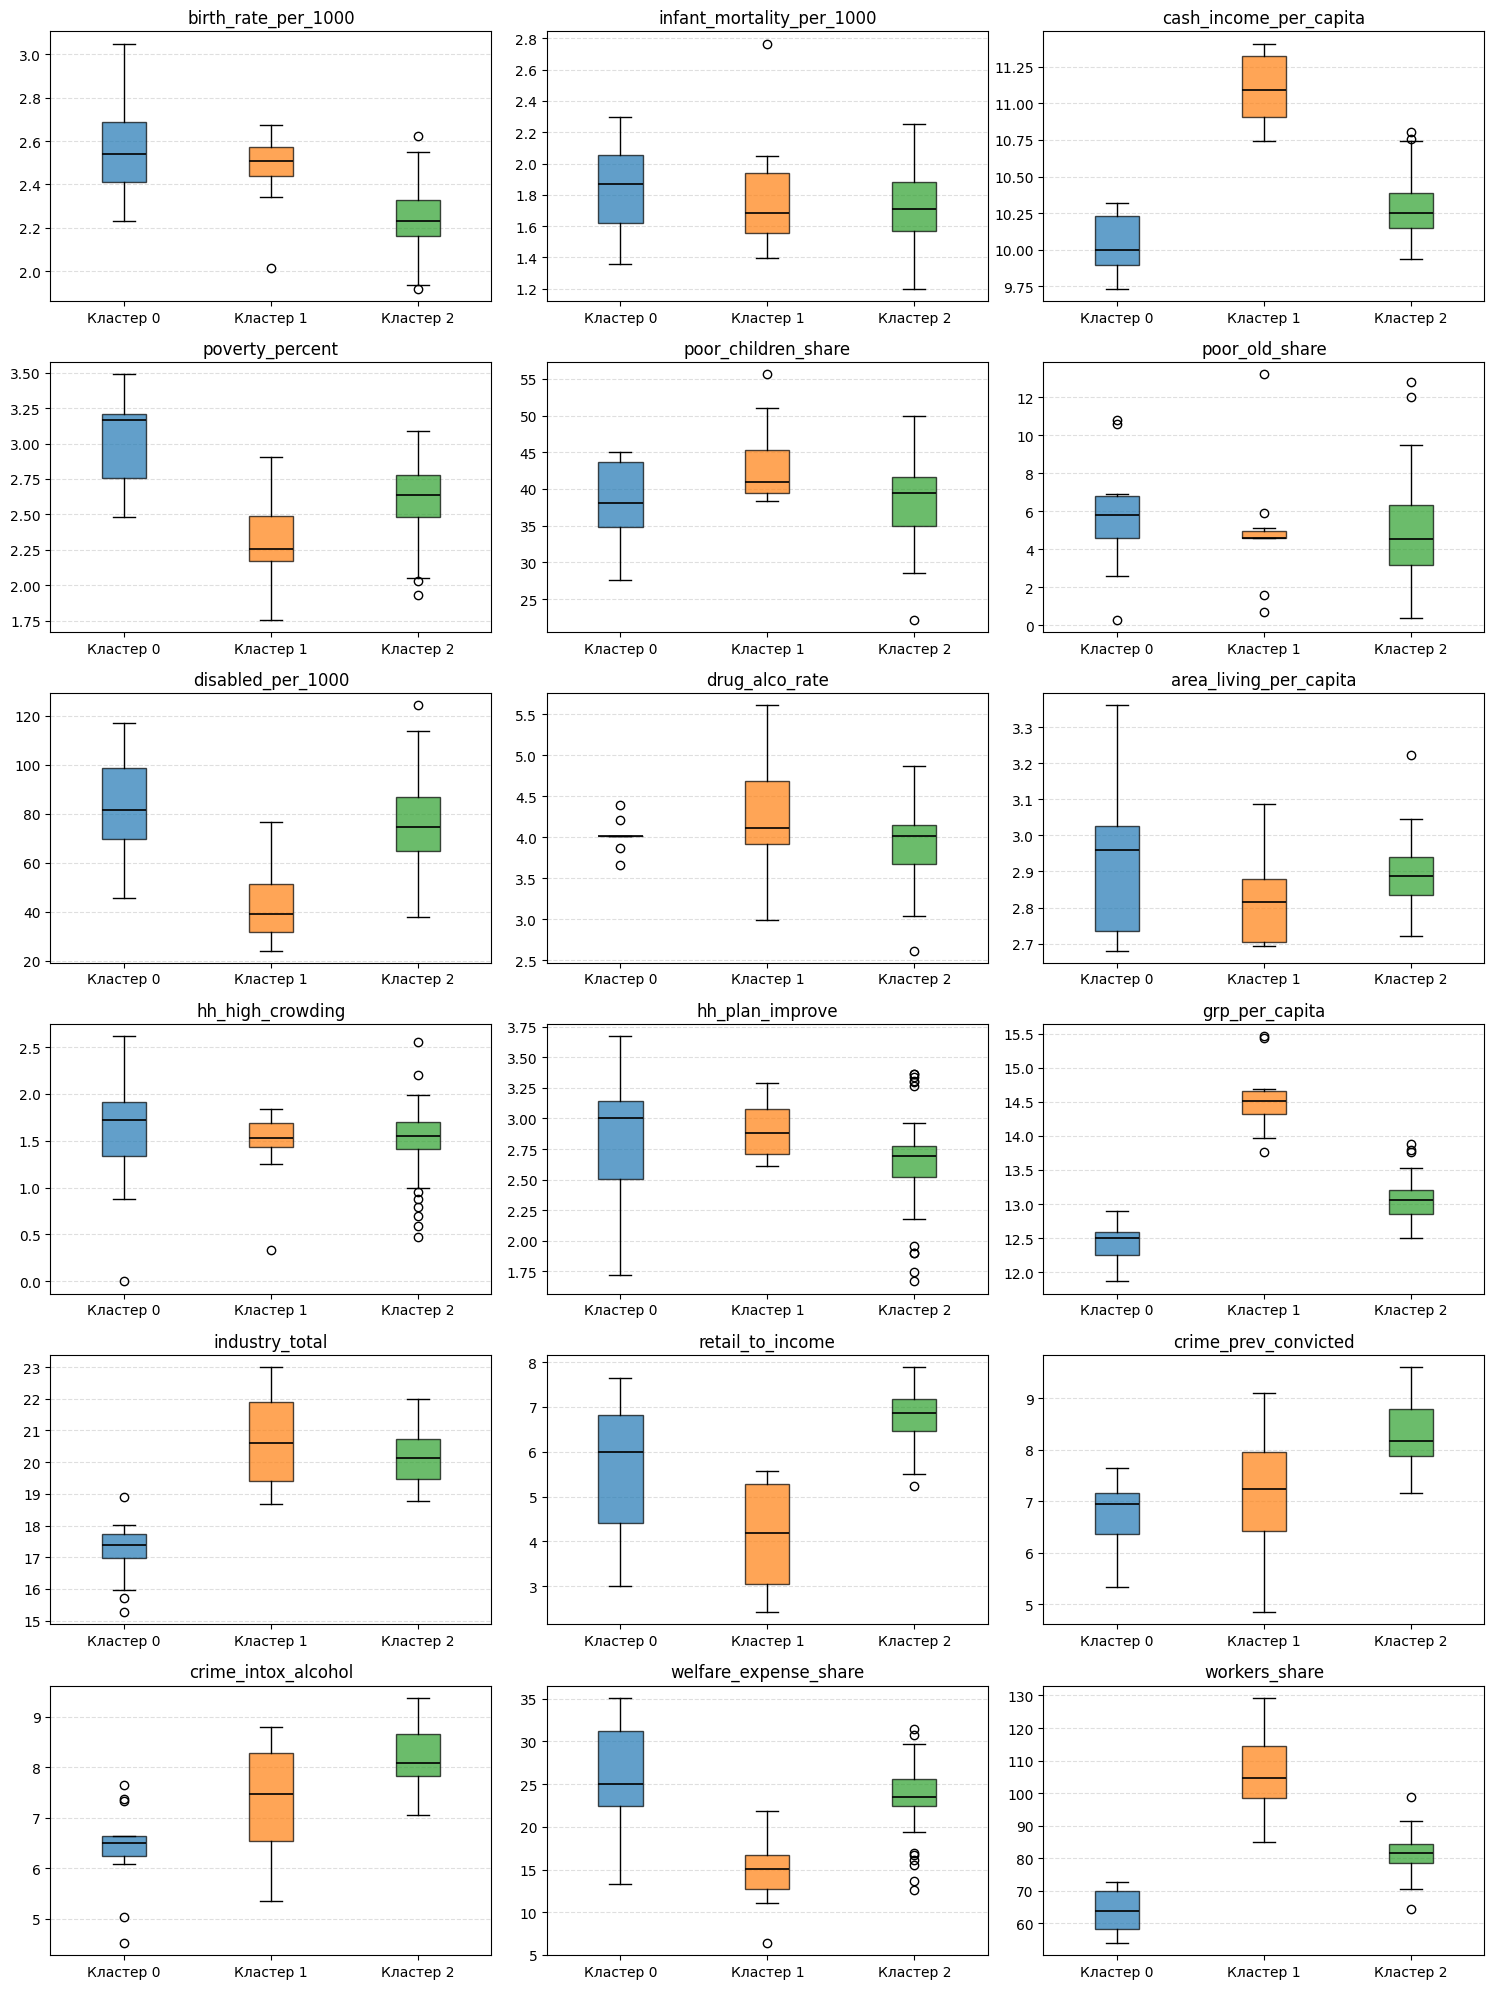

In [31]:
cluster_colors = {0: "#1f77b4",  # синий
                  1: "#ff7f0e",  # оранжевый
                  2: "#2ca02c",  # зелёный
                 }

fig, axes = plt.subplots(6, 3, figsize=(15, 20))

clusters = sorted(df_work["cluster"].unique())

for idx, col in enumerate(features_final):
    row = idx // 3
    col_pos = idx % 3
    ax = axes[row][col_pos]
    
    # данные по кластерам
    data_to_plot = [df_work.loc[df_work["cluster"] == cl, col].values for cl in clusters]
    
    bp = ax.boxplot(data_to_plot,
                    tick_labels=[f"Кластер {cl}" for cl in clusters],
                    showfliers=True,
                    patch_artist=True)
    
    # Раскрашиваем 
    for patch, cl in zip(bp['boxes'], clusters):
        patch.set_facecolor(cluster_colors[cl])
        patch.set_edgecolor("black")
        patch.set_alpha(0.7)
    
    # Медианы
    for median in bp['medians']:
        median.set_color("black")
        median.set_linewidth(1.2)
    
    ax.set_title(col)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

Анализ распределений показателей в разрезе кластеров (по описательной статистике и диаграммам размаха) показывает, что выделенные группы регионов отличаются не только по средним значениям, но и по форме распределений.

**Кластер 0** объединяет регионы с наиболее неблагоприятной ситуацией по бедности и социально-демографической уязвимости. Уровень бедности здесь стабильно выше, чем в других кластерах: медиана и квартильный размах бедности смещены вверх, а доходы на душу населения — вниз. Почти все регионы кластера имеют сходно низкие доходы, что видно по узкому разбросу показателя `cash_income_per_capita`. При этом наблюдается высокий и довольно вариативный уровень инвалидности, значительная доля бедных детей и пожилых, более высокая доля домохозяйств с сильной стеснённостью. Доля расходов на социальную политику в бюджете в кластере 0 максимальна, что отражает высокую нагрузку на систему социальной поддержки, тогда как занятость и уровень экономического развития (ВРП и промышленность) остаются низкими.

**Кластер 1** характеризуется как группа экономически сильных регионов. Распределения по доходам и ВРП на душу населения смещены вверх, а по уровню бедности - вниз: и медиана, и большая часть боксплота находятся ниже остальных кластеров. При этом занятость в кластере 1 существенно выше, чем в других группах. Вместе с тем внутри кластера сохраняется заметная неоднородность по доле бедных детей и пожилых, а также по инвалидности: на диаграммах размаха видны регионы-«выбросы» с более высокой уязвимостью отдельных групп населения. Доля социальных расходов в бюджете здесь минимальна, что сочетается с высокими собственными доходами населения и относительно благоприятной криминогенной ситуацией.

**Кластер 2** представляет собой «среднюю» группу регионов. Большинство распределений по ключевым показателям (бедность, доходы, ВРП, занятость, жилищные условия) имеют медианы и квартильные размахи, близкие к общему среднему по выборке. При этом именно в кластере 2 наблюдаются наиболее высокие медианы и верхние квартильные значения по преступлениям, в том числе совершённым ранее судимыми и в состоянии алкогольного опьянения, что указывает на более напряжённую криминогенную обстановку при формально средних социально-экономических характеристиках. Доля социальных расходов занимает промежуточное положение между кластерами 0 и 1.

В целом анализ распределений подтверждает устойчивость полученной кластеризации. Кластер 0 формирует группу регионов с комплексной социально-экономической уязвимостью (высокая бедность, низкие доходы, высокая инвалидность и значительные социальные расходы). Кластер 1 - экономически благополучные территории с высокой занятостью и низкой бедностью в среднем, но с внутренней дифференциацией по отдельным уязвимым группам. Кластер 2 объединяет основную массу регионов со средними значениями большинства показателей, но более высокой криминогенной нагрузкой. Такое сочетание характеристик оправдывает дальнейшую интерпретацию кластеров в контексте региональной социальной политики и адресной поддержки малообеспеченного населения.


#### 5.3. Детальная интерпретация кластеров по группам показателей.

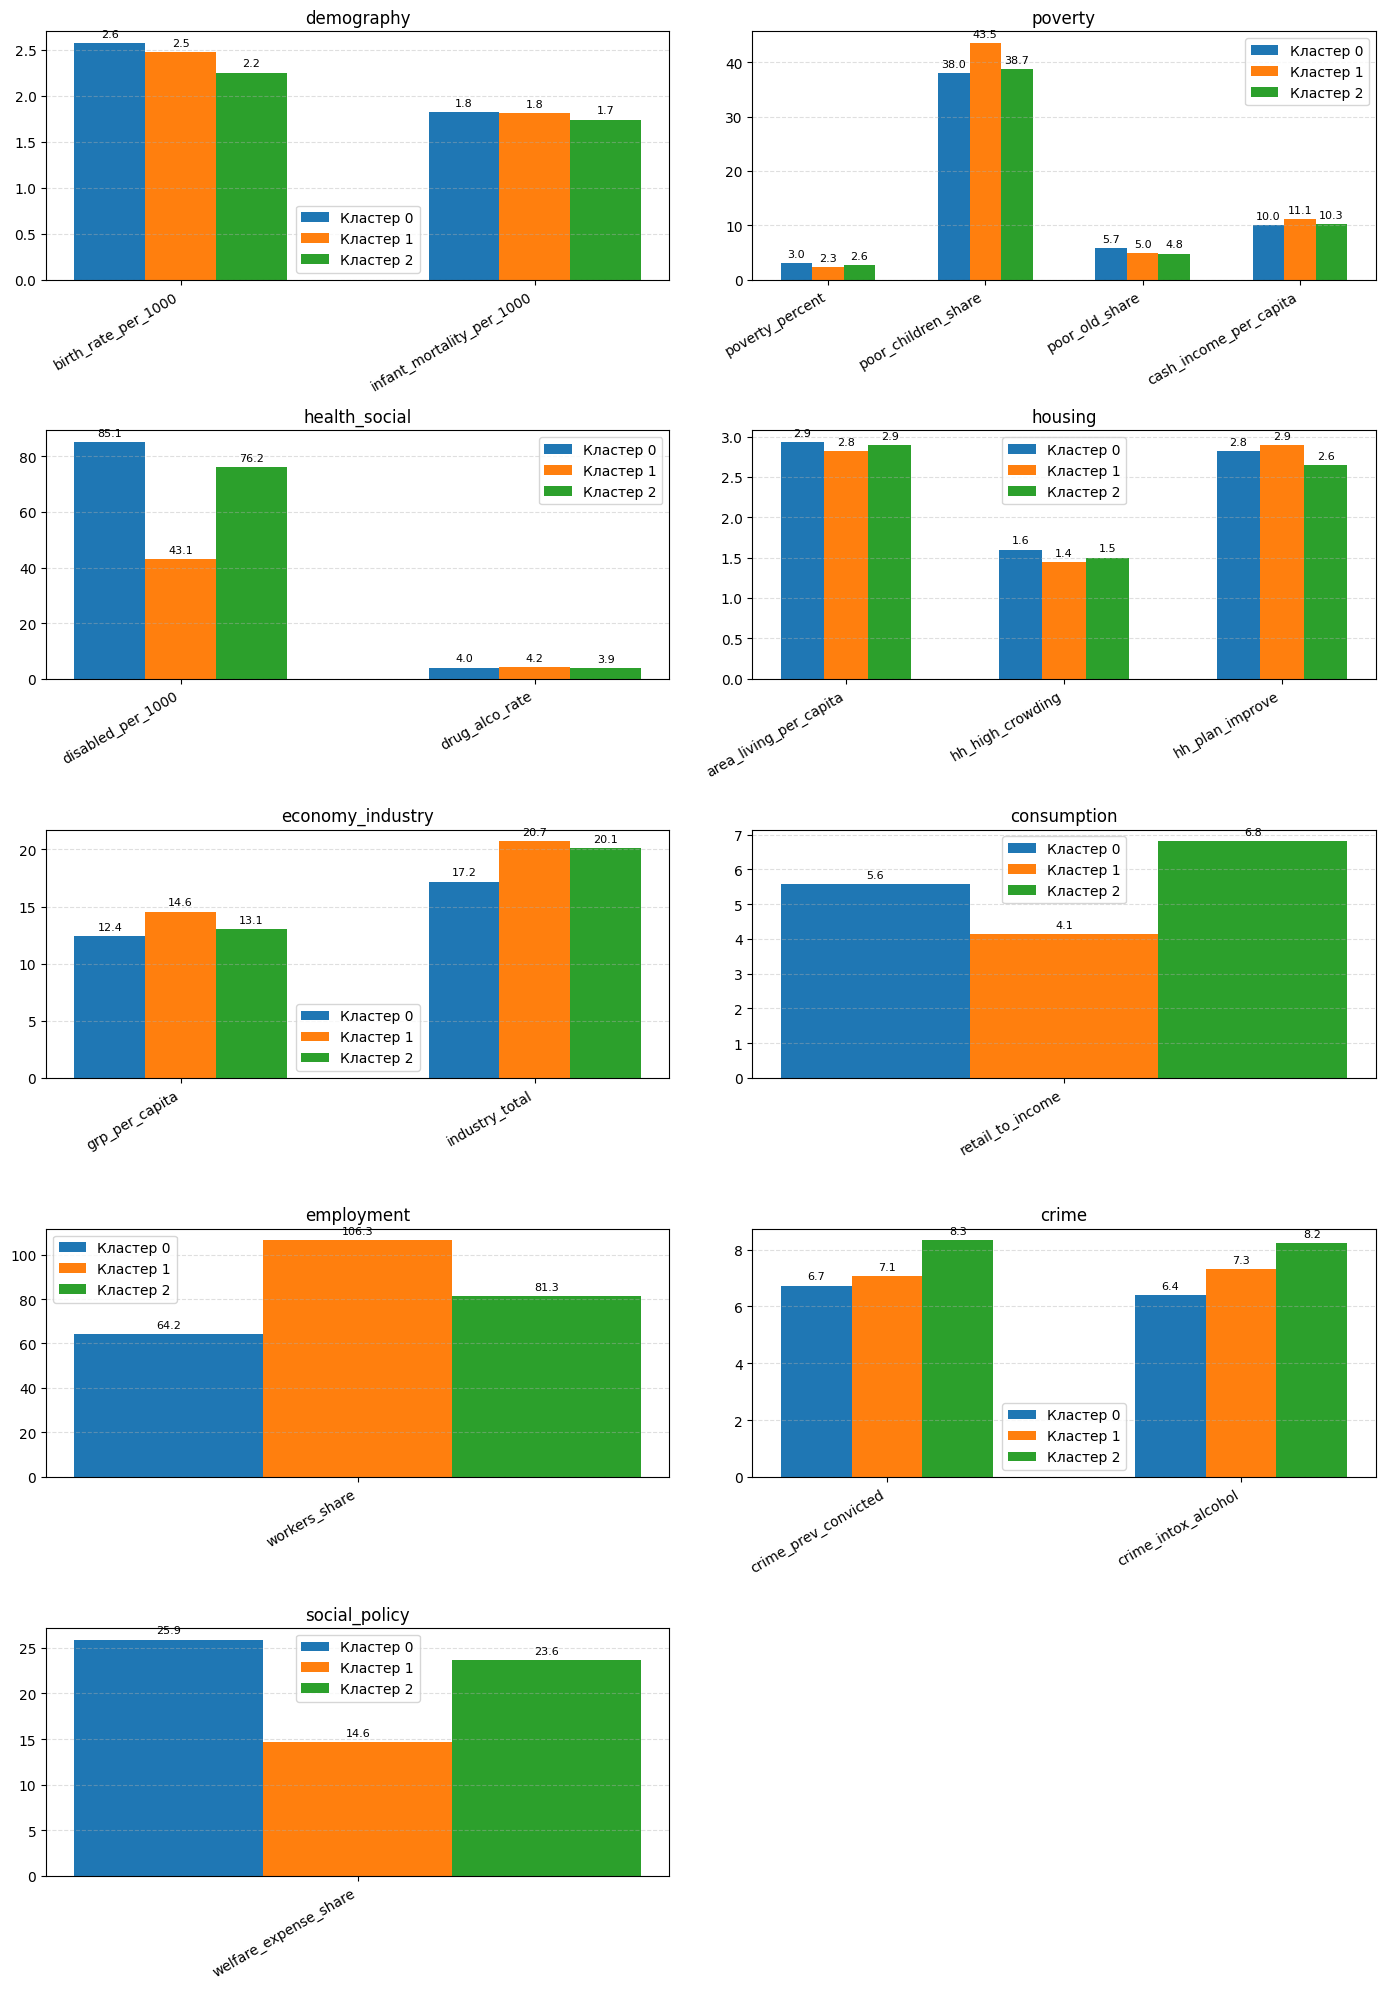

In [32]:
fig, axes = plt.subplots(5, 2, figsize=(14, 20))
axes = axes.flatten()

for ax_idx, (ax, (block_name, cols)) in enumerate(zip(axes, blocks.items())):
    
    # Данные для блока
    data_block = cluster_means[cols].T  
    indicators = data_block.index
    clusters = data_block.columns.tolist()
    
    x = np.arange(len(indicators))
    width = 0.2
    
    # Рисуем столбики по кластерам
    for i, cl in enumerate(clusters):
        bars = ax.bar(
            x + (i - 1) * width,
            data_block[cl].values,
            width,
            label=f"Кластер {cl}",
            color=cluster_colors.get(cl, None)
        )
        
        # Подписи значений над столбиками
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f"{height:.1f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # смещение вверх
                textcoords="offset points",
                ha="center", va="bottom",
                fontsize=8
            )
    
    # Оформление
    ax.set_xticks(x)
    ax.set_xticklabels(indicators, rotation=30, ha="right")
    ax.set_title(block_name)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.legend()  

# Отключаем лишние оси
for i in range(ax_idx + 1, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

***Демография***

Показатели рождаемости и младенческой смертности различаются между кластерами умеренно. В **кластере 0** рождаемость немного выше, но одновременно фиксируется повышенная младенческая смертность - это может указывать на более низкую доступность или качество медицинской помощи. **Кластеры 1 и 2** демонстрируют более низкие показатели рождаемости, но и более благоприятную ситуацию с детской смертностью.  

Демография не является главным фактором, разделяющим кластеры, однако для регионов кластера 0 сочетание более высокой рождаемости и ухудшённых медицинских показателей усиливает нагрузку на систему здравоохранения и социальную поддержку семей с детьми.

***Доходы и бедность***

Это блок, по которому различия между кластерами выражены наиболее ярко.  

- **Кластер 0** - регионы с **наиболее высокой бедностью** и самыми низкими доходами населения. Доли бедных детей и бедных пожилых также выше, чем в других кластерных группах, что отражает комплексную социальную уязвимость.
- **Кластер 1** - наиболее экономически благополучные территории. Здесь **минимальный уровень бедности** и **максимальные доходы**. При этом доля бедных детей остаётся высокой, что указывает на сильную дифференциацию доходов.
- **Кластер 2** занимает **среднее положение**: уровень бедности и доходов близок к среднероссийскому, значительных отклонений нет.

Именно этот блок формирует основное социально-экономическое расслоение регионов.

***Здоровье и социальная уязвимость***

Сюда входят показатели инвалидности и распространённости алкоголизма/наркомании.

- **Кластер 0** отличается **наибольшей инвалидностью** на 1000 человек - это усиливает социальную нагрузку регионов и потребность в поддержке.
- **Кластер 1** имеет **наименьший уровень инвалидности**, что согласуется с более благополучной экономической и социальной ситуацией.
- **Кластер 2** занимает промежуточную позицию, однако показатели девиантного поведения (алкоголь/наркотики) у него могут быть выше, чем в кластере 1, что требует внимания к вопросам профилактики и социальной работы.


***Жилищные условия***

Показатели жилищной обеспеченности дают следующие различия:

- В **кластере 0** заметна более высокая доля домохозяйств с сильной стеснённостью (hh_high_crowding), что сочетается с низкими доходами и ограниченной возможностью улучшить жильё.
- **Кластер 1** демонстрирует лучшие условия проживания, что логично при высоких доходах и развитой экономике.
- **Кластер 2** - средняя группа: обеспеченность жильём и уровень стеснённости соответствуют общей ситуации большинства субъектов.

Этот блок в меньшей степени разделяет кластеры, но усиливает различия, обусловленные бедностью.


***Экономическое развитие и промышленность***

По уровню промышленного производства и ВРП различия выражены сильно.

- **Кластер 1** - абсолютный лидер: высокие значения GRP и промышленного производства подтверждают, что это сырьевые, экономически сильные регионы и Москва.
- **Кластер 0** - слабейший по уровню экономического развития. Низкий GRP ограничивает возможности населения по выходу из бедности.
- **Кластер 2** - опять средняя позиция: показатели выше, чем у кластера 0, но значительно ниже, чем у кластера 1.


***Потребление***

Показатель retail_to_income (отношение розничного оборота к доходам):

- В **кластере 1** он ниже, отражая более высокие доходы (населению не приходится тратить так много относительно своего бюджета).
- В **кластере 0** и **кластере 2** значение выше, что указывает на большую бюджетную нагрузку домохозяйств - особенно у малообеспеченных регионов.


***Занятость***

Показатель workers_share:

- В **кластере 1** занятость наиболее высокая - ещё одно подтверждение сильной экономики.
- В **кластере 0** - самая низкая занятость, что усиливает бедность и ограничивает социальную мобильность.
- **Кластер 2** показывает типичные значения, близкие к среднероссийским.


***Преступность***

- В **кластере 2** фиксируются **наиболее высокие показатели преступлений**, в том числе преступлений ранее судимых. Это говорит о социальной напряжённости, не всегда напрямую связанной с бедностью.
- **Кластер 0** имеет ниже средние уровни преступности, что может объясняться спецификой национальных республик, более высокой плотностью социальных связей и более строгими социальными нормами.
- **Кластер 1** демонстрирует наиболее благополучную криминогенную ситуацию.


***Социальная политика***

- В **кластере 0** доля расходов на социальную политику самая высокая - логично, учитывая низкие доходы и высокую нуждаемость населения.
- В **кластере 1** этот показатель минимален: высокая экономическая база снижает необходимость больших социальных вложений.
- **Кластер 2** находится между ними.

В целом это подтверждает, что регионы кластера 0 несут наибольшую нагрузку по поддержке малообеспеченных слоёв населения, кластер 1 - наиболее самодостаточен, а кластер 2 демонстрирует смешанный тип.

#### 5.4. Полярная диаграмма профиля кластеров.

##### 5.4.1. Выбор показателей для радарной диаграммы.

Возьмём по смыслу из разных блоков, чтобы получить портрет кластера:
- `poverty_percent` - уровень бедности
- `poor_children_share` - бедные дети
- `cash_income_per_capita` - доходы
- `disabled_per_1000` - инвалиды
- `drug_alco_rate` - нарко-/алкозависимости
- `area_living_per_capita` - жильё
- `grp_per_capita` - экономика
- `crime_prev_convicted` - преступность
- `welfare_expense_share` - социальные расходы
- `workers_share` - занятость

In [33]:
radar_features = ["poverty_percent", "poor_children_share", "cash_income_per_capita",
                  "disabled_per_1000", "drug_alco_rate", "area_living_per_capita",
                  "grp_per_capita", "crime_prev_convicted", "welfare_expense_share",
                  "workers_share"]

radar_labels = {"poverty_percent": "Бедность, %",
                "poor_children_share": "Бедные дети, %",
                "cash_income_per_capita": "Доходы на душу",
                "disabled_per_1000": "Инвалиды на 1000",
                "drug_alco_rate": "Алко/нарко на 100 тыс.",
                "area_living_per_capita": "Жилая площадь на 1 чел",
                "grp_per_capita": "ВРП на душу",
                "crime_prev_convicted": "Преступления\nранее судимых",
                "welfare_expense_share": "Доля соцрасходов",
                "workers_share": "Занятые, %"}


##### 5.4.2. Нормализация средних значений по кластерам.

In [34]:
radar_data = cluster_means[radar_features].copy()

scaler = MinMaxScaler()
radar_norm_arr = scaler.fit_transform(radar_data)

# превращаем обратно в DataFrame
radar_norm = pd.DataFrame(radar_norm_arr,
                          index=radar_data.index, 
                          columns=radar_data.columns)

##### 5.4.3. Построение диаграмм.

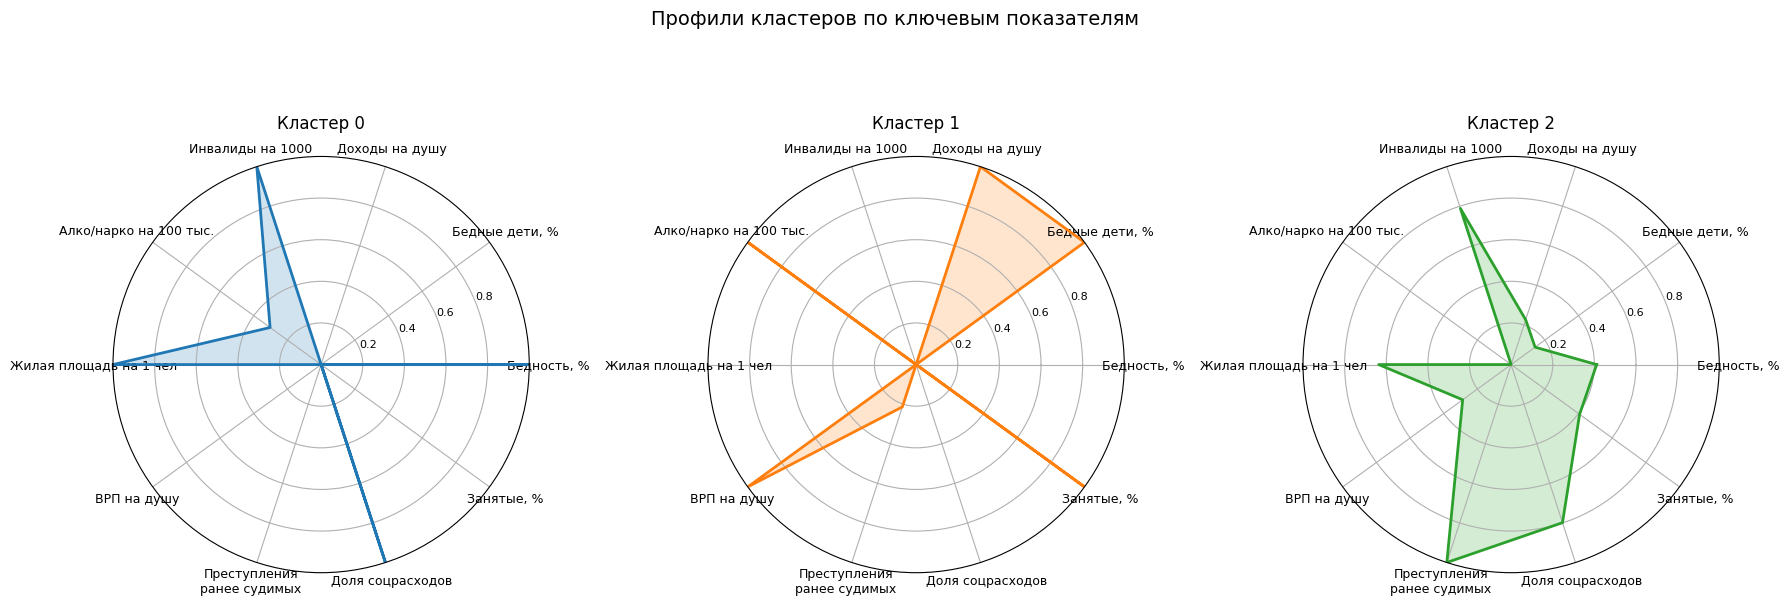

In [35]:
indicators = radar_features
N = len(indicators)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # замыкаем круг


# Строим три полярные диаграммы в ряд
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 6),
    subplot_kw=dict(polar=True)
)

for ax, cl in zip(axes, radar_norm.index):
    values = radar_norm.loc[cl, indicators].tolist()
    values += values[:1]  # замыкаем линию
    
    ax.plot(
        angles,
        values,
        linewidth=2,
        color=cluster_colors.get(cl, None),
    )
    ax.fill(
        angles,
        values,
        alpha=0.2,
        color=cluster_colors.get(cl, None),
    )
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([radar_labels[f] for f in indicators], fontsize=9)
    
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], fontsize=8)
    ax.set_ylim(0, 1)
    
    ax.set_title(f"Кластер {cl}", fontsize=12, pad=10)

fig.suptitle("Профили кластеров по ключевым показателям",
             fontsize=14,
             y=1.05)

plt.tight_layout()
plt.show()

Форма полярных диаграмм показывает, что у каждого кластера формируется свой характерный «социально-экономический профиль».

- **Кластер 0** имеет на диаграмме наиболее вытянутые лучи по показателям бедности и социальной уязвимости: нормированные значения уровня бедности, доли бедных пожилых, инвалидности и доли социальных расходов заметно превышают соответствующие показатели других кластеров. При этом лучи, отражающие доходы, ВРП на душу населения и занятость, остаются укороченными. Таким образом, полярная диаграмма кластера 0 наглядно фиксирует сочетание низкого уровня экономического развития и занятости с высокой нагрузкой бедности и значительными социальными расходами, что подтверждает интерпретацию этого кластера как группы наиболее уязвимых регионов.

- **Кластер 1**, напротив, характеризуется максимальными значениями по оси доходов, ВРП на душу населения и занятости: соответствующие лучи на полярной диаграмме заметно длиннее, чем у остальных кластеров. Одновременно луч бедности здесь укорочен, что отражает более низкий средний уровень бедности. В то же время по доле бедных детей и отдельным показателям социальной уязвимости профиль кластера 1 не всегда минимален, что говорит о наличии внутри этой группы территорий с локальными очагами неблагополучия. В целом диаграмма кластера 1 иллюстрирует профиль экономически благополучных регионов с высокой занятостью и доходами, где основным вызовом является не массовая бедность, а дифференциация условий жизни отдельных групп населения.

- **Кластер 2** занимает промежуточное положение практически по всем осям: нормированные значения доходов, бедности, инвалидности, обеспеченности жильём и социальных расходов располагаются между профилями кластеров 0 и 1. При этом по показателям преступности и преступлений, совершённых ранее судимыми и в состоянии алкогольного опьянения, лучи кластера 2 оказываются наиболее вытянутыми. Это подчёркивает специфику данной группы: при формально средних социально-экономических параметрах регионы кластера 2 сталкиваются с более высокой криминогенной нагрузкой и рисками девиантного поведения населения.

В совокупности полярные диаграммы подтверждают осмысленность выделенных кластеров и позволяют визуально охарактеризовать их как три различных типа регионов: 
1) регионы с комплексной социальной уязвимостью и высокой нагрузкой бедности (кластер 0),  
2) экономически развитые регионы с высокой занятостью и относительно низкой бедностью (кластер 1),  
3) «средние» регионы с умеренными значениями большинства показателей, но повышенной криминогенной напряжённостью (кластер 2).  

Такая визуализация помогает не только сравнить кластеры между собой, но и увязать их профили с возможными направлениями дифференцированной социальной и региональной политики.


#### 5.5. Проверка статистической значимости различий между кластерами (тест Краскела-Уоллиса).

Для того чтобы убедиться, что различия между полученными кластерами по социально-экономическим показателям являются не случайными, а статистически значимыми, применим непараметрический тест Краскела-Уоллиса. Этот тест позволяет сравнивать несколько групп (в нашем случае - три кластера) по одному признаку и проверять гипотезу о равенстве распределений. 

- Нулевая гипотеза (H_0): распределения значения показателя в трёх кластерах одинаковы. 
- Альтернативная гипотеза (H_1): хотя бы для одного кластера распределение отличается от остальных.

In [36]:
results = []

for col in features_final:
    groups = [df_work.loc[df_work["cluster"] == cl, col] for cl in clusters]
    
    stat, p = kruskal(*groups)
    results.append({"feature": col,
                    "H_stat": stat,
                    "p_value": p
                   })

kw_results = (pd.DataFrame(results).sort_values("p_value").reset_index(drop=True))

alpha_1 = 0.05
alpha_2 = 0.01

kw_results["significant_0.05"] = kw_results["p_value"] < alpha_1
kw_results["significant_0.01"] = kw_results["p_value"] < alpha_2

kw_results["H_stat"] = kw_results["H_stat"].round(3)
kw_results["p_value"] = kw_results["p_value"].round(4)

display(kw_results)

,feature,H_stat,p_value,significant_0.05,significant_0.01
0,workers_share,47.182,0.0000,True,True
1,grp_per_capita,44.836,0.0000,True,True
2,cash_income_per_capita,34.583,0.0000,True,True
3,crime_prev_convicted,34.211,0.0000,True,True
4,industry_total,32.684,0.0000,True,True
5,crime_intox_alcohol,31.833,0.0000,True,True
6,retail_to_income,30.457,0.0000,True,True
7,birth_rate_per_1000,30.158,0.0000,True,True
8,poverty_percent,22.470,0.0000,True,True
9,welfare_expense_share,21.987,0.0000,True,True


Результаты теста Краскела-Уоллиса показали, что по большинству признаков различия между кластерами являются статистически значимыми. На уровне значимости 0,05 (и даже 0,01) нулевая гипотеза о равенстве распределений отклоняется для следующих показателей: доля занятых (`workers_share`),
валовой региональный продукт на душу населения (`grp_per_capita`), доходы населения (`cash_income_per_capita`), показатели преступности (`crime_prev_convicted`, `crime_intox_alcohol`), общий объём промышленного производства (`industry_total`), отношение розничного товарооборота к доходам (`retail_to_income`), рождаемость (`birth_rate_per_1000`), уровень бедности (`poverty_percent`), доля расходов на социальную политику (`welfare_expense_share`), а также инвалидность на 1000 жителей (`disabled_per_1000`). Это означает, что кластеры действительно различаются
по уровню экономического развития, занятости, бедности, социальной нагрузке и криминогенной ситуации.

В то же время для ряда показателей статистически значимых различий между кластерами не выявлено (p ≥ 0,05): доли домохозяйств, планирующих улучшить
жилищные условия (`hh_plan_improve`), обеспеченности жилой площадью (`area_living_per_capita`), доли детей и пожилых среди малоимущих (`poor_children_share`, `poor_old_share`), распространённости алкоголизма/наркоманий (`drug_alco_rate`), стеснённости домохозяйств (`hh_high_crowding`) и младенческой смертности (`infant_mortality_per_1000`). Это согласуется с визуальным анализом распределений и показывает, что по этим показателям различия между кластерами менее выражены.

В целом применение теста Краскела-Уоллиса подтверждает, что полученная кластеризация отражает реальные и статистически значимые различия между группами регионов по ключевым социально-экономическим характеристикам.

#### 5.6. Попарное сравнение кластеров (тест Манна-Уитни).

Тест Краскела-Уоллиса показал, что по ряду показателей существуют статистически значимые различия между тремя кластерами регионов. Для того чтобы определить, между какими именно кластерами наблюдаются эти различия, выполним еще попарное сравнение кластеров с использованием непараметрического теста Манна-Уитни.

- Нулевая гипотеза (H_0): распределения значения показателя в двух сравниваемых кластерах одинаковы.
- Альтернативная гипотеза (H_1): распределения различаются.

In [37]:
pairs = [(0, 1),(0, 2),(1, 2)]

results_mw = []

for col in features_final:
    for (c1, c2) in pairs:
        x = df_work.loc[df_work["cluster"] == c1, col]
        y = df_work.loc[df_work["cluster"] == c2, col]
        
        stat, p = mannwhitneyu(x, y, alternative="two-sided")
        
        results_mw.append({"feature": col,
                           "cluster_1": c1,
                           "cluster_2": c2,
                           "U_stat": stat,
                           "p_value": p
                          })

mw_results = (pd.DataFrame(results_mw).sort_values("p_value").reset_index(drop=True))

mw_results["significant_0.05"] = mw_results["p_value"] < alpha_1
mw_results["significant_0.01"] = mw_results["p_value"] < alpha_2

mw_results["U_stat"] = mw_results["U_stat"].round(1)
mw_results["p_value"] = mw_results["p_value"].round(4)

mw_01 = mw_results[(mw_results["cluster_1"] == 0) & (mw_results["cluster_2"] == 1)]
mw_02 = mw_results[(mw_results["cluster_1"] == 0) & (mw_results["cluster_2"] == 2)]
mw_12 = mw_results[(mw_results["cluster_1"] == 1) & (mw_results["cluster_2"] == 2)]

print("Сравнение кластера 0 и кластера 1")
display(mw_01.sort_values("p_value").head(10))
print("\nСравнение кластера 0 и кластера 2")
display(mw_02.sort_values("p_value").head(10))
print("\nСравнение кластера 1 и кластера 2")
display(mw_12.sort_values("p_value").head(10))

Сравнение кластера 0 и кластера 1


,feature,cluster_1,cluster_2,U_stat,p_value,significant_0.05,significant_0.01
12,workers_share,0,1,0.0,0.0001,True,True
13,grp_per_capita,0,1,0.0,0.0001,True,True
14,cash_income_per_capita,0,1,0.0,0.0001,True,True
15,industry_total,0,1,1.0,0.0001,True,True
18,disabled_per_1000,0,1,122.0,0.0005,True,True
19,poverty_percent,0,1,122.0,0.0005,True,True
20,welfare_expense_share,0,1,121.5,0.0005,True,True
27,poor_children_share,0,1,30.0,0.0315,True,False
29,retail_to_income,0,1,99.0,0.0377,True,False
31,crime_intox_alcohol,0,1,36.0,0.0771,False,False



Сравнение кластера 0 и кластера 2


,feature,cluster_1,cluster_2,U_stat,p_value,significant_0.05,significant_0.01
0,industry_total,0,2,3.0,0.0000,True,True
1,crime_intox_alcohol,0,2,11.0,0.0000,True,True
2,crime_prev_convicted,0,2,13.0,0.0000,True,True
3,workers_share,0,2,17.0,0.0000,True,True
7,grp_per_capita,0,2,50.0,0.0000,True,True
9,birth_rate_per_1000,0,2,733.0,0.0000,True,True
16,poverty_percent,0,2,679.5,0.0001,True,True
21,cash_income_per_capita,0,2,163.0,0.0008,True,True
22,retail_to_income,0,2,184.0,0.0022,True,True
32,disabled_per_1000,0,2,510.0,0.1361,False,False



Сравнение кластера 1 и кластера 2


,feature,cluster_1,cluster_2,U_stat,p_value,significant_0.05,significant_0.01
4,cash_income_per_capita,1,2,617.0,0.0000,True,True
5,grp_per_capita,1,2,617.0,0.0000,True,True
6,retail_to_income,1,2,5.0,0.0000,True,True
8,workers_share,1,2,605.0,0.0000,True,True
10,welfare_expense_share,1,2,32.5,0.0000,True,True
11,disabled_per_1000,1,2,60.0,0.0000,True,True
17,birth_rate_per_1000,1,2,533.0,0.0003,True,True
23,crime_prev_convicted,1,2,125.0,0.0027,True,True
24,poverty_percent,1,2,145.0,0.0074,True,True
25,area_living_per_capita,1,2,168.0,0.0211,True,False


Результаты попарного сравнения кластеров с использованием теста Манна-Уитни позволяют детализировать различия между группами регионов.

**Кластер 0 vs кластер 1.**  
Между социально уязвимыми регионами (кластер 0) и экономически развитыми регионами (кластер 1) выявлены статистически значимые отличия по целому
ряду показателей. При уровне значимости 0,01 различаются доля занятых (`workers_share`), ВРП на душу населения (`grp_per_capita`), доходы населения
(`cash_income_per_capita`), объём промышленного производства (`industry_total`), инвалидность (`disabled_per_1000`), уровень бедности (`poverty_percent`) и доля расходов на социальную политику (`welfare_expense_share`). На уровне 0,05 дополнительно обнаружены различия
по доле детей среди малоимущих (`poor_children_share`) и отношению розничного товарооборота к доходам (`retail_to_income`). Это подтверждает, что кластер 0 существенно отстаёт от кластера 1 по экономическому развитию и занятости, демонстрирует более высокую бедность и большую социальную нагрузку, тогда как кластер 1 сочетает более высокие доходы и занятость с меньшей потребностью в бюджетной социальной поддержке.

**Кластер 0 vs кластер 2.**  
Сравнение социально уязвимых регионов (кластер 0) с «средними» регионами (кластер 2) также показывает статистически значимые различия по ключевым
показателям. При уровне значимости 0,01 кластеры отличаются по объёму промышленного производства (`industry_total`), преступлениям в состоянии
алкогольного опьянения (`crime_intox_alcohol`), преступлениям ранее судимых (`crime_prev_convicted`), доле занятых (`workers_share`), ВРП на душу населения (`grp_per_capita`), рождаемости (`birth_rate_per_1000`), уровню бедности (`poverty_percent`), доходам населения (`cash_income_per_capita`) и
отношению розничного товарооборота к доходам (`retail_to_income`). Различия по инвалидности (`disabled_per_1000`) статистически не подтверждаются. В целом это означает, что регионы кластера 2 занимают промежуточное положение: они экономически развитее и менее бедны, чем кластер 0, но при этом имеют
более высокую криминогенную нагрузку.

**Кластер 1 vs кластер 2.**  
При сравнении экономически развитых регионов (кластер 1) с «средними» регионами (кластер 2) статистически значимые различия на уровне 0,01 выявлены по
показателям доходов населения (`cash_income_per_capita`), ВРП на душу населения (`grp_per_capita`), отношения розничного оборота к доходам (`retail_to_income`), доли занятых (`workers_share`), доли расходов на социальную политику (`welfare_expense_share`), инвалидности (`disabled_per_1000`), рождаемости (`birth_rate_per_1000`), преступлений ранее судимых (`crime_prev_convicted`) и уровня бедности (`poverty_percent`). На уровне 0,05 дополнительно отмечены различия по обеспеченности жилой площадью (`area_living_per_capita`). Это подтверждает, что кластер 1 существенно опережает кластер 2 по экономическим показателям и занятости, при более низкой бедности и меньшей инвалидности, тогда как регионы кластера 2 остаются в промежуточной зоне по уровню благополучия.

В совокупности результаты теста Манна-Уитни показывают, что наибольший разрыв в социально-экономическом развитии наблюдается между кластерами 0 и 1, тогда как кластер 2 занимает промежуточное положение, отличаясь и от уязвимых, и от экономически благополучных регионов по ключевым показателям.

#### 5.7. Приоритизация регионов внутри кластера 0.

Для того чтобы выявить регионы, находящиеся в наиболее сложной ситуации, выполним приоритизацию по ключевым индикаторам уязвимости. Регион считается более уязвимым, если он одновременно имеет высокие показатели бедности, высокую долю детей и пожилых среди малоимущих, повышенную инвалидность и низкий уровень доходов.


In [38]:
priority_cols = ["poverty_percent",
                 "poor_children_share",
                 "poor_old_share",
                 "cash_income_per_capita",
                 "disabled_per_1000"]

cluster0 = df_work[df_work["cluster"] == 0].copy()
# Сортируем по бедности
priority_cluster0 = cluster0.sort_values(["poverty_percent", "poor_children_share", "cash_income_per_capita"],ascending=[False, False, True])

priority_cluster0[["region"] + priority_cols].head(5)

,region,poverty_percent,poor_children_share,poor_old_share,cash_income_per_capita,disabled_per_1000
58,Республика Тыва,3.487375,45.0,2.6,9.850772,63.415022
48,Республика Ингушетия,3.433987,38.1,10.6,9.733766,116.453444
15,Кабардино-Балкарская Республика,3.226844,35.9,6.7,9.996887,64.995681
44,Республика Алтай,3.210844,44.5,2.9,9.984053,93.981770
11,Еврейская автономная область,3.202746,34.8,10.8,10.241708,77.363318


Данные регионы могут рассматриваться как регионы первоочередной поддержки.

#### 5.8. "Зона скрытого риска".

Помимо выделения социально уязвимых регионов кластера 0, определим топ-5 регионов внутри кластера 2, которые обладают неблагоприятными значениями ключевых социально-экономических показателей (бедность, доля детей среди малоимущих, низкие доходы, высокая инвалидность). 

In [39]:
cluster2 = df_work[df_work["cluster"] == 2].copy()

top5_risk = cluster2.sort_values(["poverty_percent", "poor_children_share", "cash_income_per_capita", "disabled_per_1000"],
                                  ascending=[False, False, True, False])

top5_risk[["region"] + priority_cols].head(5)    

,region,poverty_percent,poor_children_share,poor_old_share,cash_income_per_capita,disabled_per_1000
12,Забайкальский край,3.086487,33.4,7.2,10.205331,71.738228
46,Республика Бурятия,3.039749,41.7,3.7,10.169422,74.938865
25,Курганская область,3.010621,39.4,2.4,9.992460,85.672042
59,Республика Хакасия,2.970414,43.2,2.4,10.079036,50.018530
14,Иркутская область,2.923162,41.5,7.0,10.224556,85.552275


Эти регионы можно рассматривать как «зону скрытого риска» - территории, которые при неблагоприятных изменениях могут сместиться ближе к профилю 
кластера 0 и потребовать усиления мер социальной поддержки.

### 6. Валидация и воспроизводимость решения.

Для оценки качества и устойчивости полученного решения, а также для обеспечения воспроизводимости экспериментов было сделано: 

1) Весь процесс анализа данных и построения модели кластеризации реализован в виде единого воспроизводимого пайплайна: от загрузки и предобработки данных до расчёта признаков, обучения модели и визуализации результатов. Все шаги выполняются в одном ноутбуке, что позволяет полностью восстановить эксперименты по исходным данным.

2) Для алгоритмов, использующих случайную инициализацию (кластеризация k-means, понижение размерности на основе случайных компонент и др.), были фиксированы значения параметра `random_state`. Это гарантирует, что при повторном запуске кода будут получены те же результаты кластеризации, а, следовательно, и те же выводы по группам регионов.

Корректность кластеризации подтверждается внутренними критериями качества (средние значения признаков по кластерам, диаграммы размаха, полярные диаграммы профилей) и статистическими тестами (Краскела-Уоллиса и Манна-Уитни), которые демонстрируют статистически значимые различия между кластерами по ключевым социально-экономическим показателям. Таким образом, постановка экспериментов и организация кода обеспечивают воспроизводимость решения и корректность интерпретации результатов.

### 7. Практическая значимость и возможность внедрения

Предложенное решение опирается на относительно простые и хорошо интерпретируемые методы анализа данных (описательная статистика, кластеризация k-means,
непараметрические статистические тесты), что делает его понятным и удобным для использования в задачах регионального анализа и мониторинга бедности.

Дополнительным преимуществом является разработанный автоматизированный пайплайн (скрипт *pipeline.py*), который полностью воспроизводит процесс обработки данных: от загрузки свежей статистики и предобработки до кластеризации регионов и формирования итогового отчёта. Пайплайн позволяет запускать обновление результатов одной командой и исключает ручные ошибки, обеспечивая стабильность, однородность и прозрачность анализа.

С точки зрения вычислительной сложности модель также является лёгкой: объём данных невелик, а используемые методы не требуют значительных ресурсов. Это позволяет легко внедрить разработанный пайплайн в регулярный процесс обновления данных - например, ежегодный пересмотр кластеров по мере поступления новых статистических показателей.

Таким образом, решение может быть реализовано в продакшене: достаточно подключить актуальный источник данных и запускать готовый скрипт, который обновит кластеры регионов, выделит наиболее уязвимые территории и сформирует аналитический отчёт для органов управления социальной политикой.

### Выводы: 

В рамках проведённого исследования была выполнена комплексная работа по анализу социально-экономического положения регионов России и факторов, связанных с бедностью и уязвимостью населения. На основе систематизированных данных была построена модель кластеризации, позволившая выделить три устойчивые группы регионов со схожими профилями. 

Полученная типология регионов представляет собой важный аналитический инструмент, который позволяет увидеть не только общие закономерности, но и существенные межрегиональные различия в структуре бедности, уровне доходов и доступности социальных ресурсов.

Полученные результаты подчёркивают необходимость **дифференцированной социальной и региональной политики**, ориентированной на особенности каждого кластера:

- для кластера 0 — **комплексная поддержка уязвимых категорий населения, развитие человеческого капитала, расширение программ уменьшения бедности**;
- для кластера 1 — **сглаживание внутреннего неравенства, обеспечение доступности социальных услуг и повышение качества городской среды**;
- для кластера 2 — **адресные меры по устранению локальных проблем и стимулирование устойчивого экономического развития**.


### Итоги:

Проделанная работа представляет собой значимый вклад в понимание региональных различий в уровне жизни населения и создаёт основу для дальнейших исследований в сфере социально-экономического развития России. Проведённое исследование не только выявило структуру бедности и её ключевые факторы, но и позволило сформировать аналитическую основу для разработки эффективных мер социальной политики. 